In [ ]:
!pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 38.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 88.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.3-cp311-cp311-linux_x86_64.whl size=7247582 sha256=5b9e4732429ea1b7376f0ac94be61c40ee2be2d29a527ba6e2f1b63003308ef3
  Stored in directory: /root/.cache/pip/wheels/c9/11/a2/86492071506a487bcba7015b710a9e89d66ca69845512fb86c
  Created wheel for biom-format: filename=biom_format-2.1.16-cp311-cp311-linux_x86_64.whl size=12173173 sha256=87fe389cfba17c95c8bc74efc8281b622c33bca6a31ca80ec9760c35b72ed1c5
  Stored in directory: /root/.cache/pip/wheels/a5/6b/58/a879e8fbae2479a3d1a68719f3a062fe62701d6494f1b74f5e
Successf

In [ ]:
# Data processing
import pandas as pd
import numpy as np

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Machine learning library
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define data
preprocess = "for_preprocess.csv"
MIPMLP = "MIPMLP.csv"
MIPMLP_mean = "MIPMLP_mean.csv"
MIPMLP_without_z_score = "MIPMLP_format.csv"
metadata = "metadata.csv"
otu = "otu_1.csv"

# Read data
df_preprocess = pd.read_csv(preprocess)
df_MIPMLP = pd.read_csv(MIPMLP)
df_MIPMLP_mean = pd.read_csv(MIPMLP_mean)
df_MIPMLP_without_z_score = pd.read_csv(MIPMLP_without_z_score)
df_MIPMLP_without_z_score.index = df_MIPMLP_mean.index
df_metadata = pd.read_csv(metadata)
df_otu = pd.read_csv(otu)

# Adjust preprocess file
df_preprocess_ID = df_preprocess["ID"]
df_preprocess_taxonomy = df_preprocess.iloc[-1:]
df_preprocess = df_preprocess.iloc[:-1, 1:]

# Define parameters
columns = df_metadata.columns
numeric_columns = ['bmi', 'fibrinogen', 'hba1c', 'creat', 'cholesterol', 'trig', 'hdl', 'ldl', 'albumin', 'glucose',
                   'alk_phos', 'ast', 'crp', 'School_YR', 'Age', 'mean_moten', 'mean_agan', 'mean_systolic', 'mean_dystolic', 'mean_dofek',
                   'kdm', 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'Psych_Dist', 'insulin', 'viol_total']  # , 'insulin', 'viol_total',
categorical_columns = ['SMOKING', 'ALCOHOL', 'income1']
binary_columns = ['SEX_0M', 'DIABET', 'CANCER', 'RESPIRATO', 'CVD', 'DEPRES', 'DRUG_2WKS', 'DIET Q38']
Target_columns = [ 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'viol_total', 'Psych_Dist', 'fibrinogen', 'crp']
Supervised_columns = ['bmi', 'SEX_0M', 'Age']

# Turn metadata numeric columns into numeric type
for col in numeric_columns:
    df_metadata[col] = pd.to_numeric(df_metadata[col], errors='coerce')


# **Outlayers**

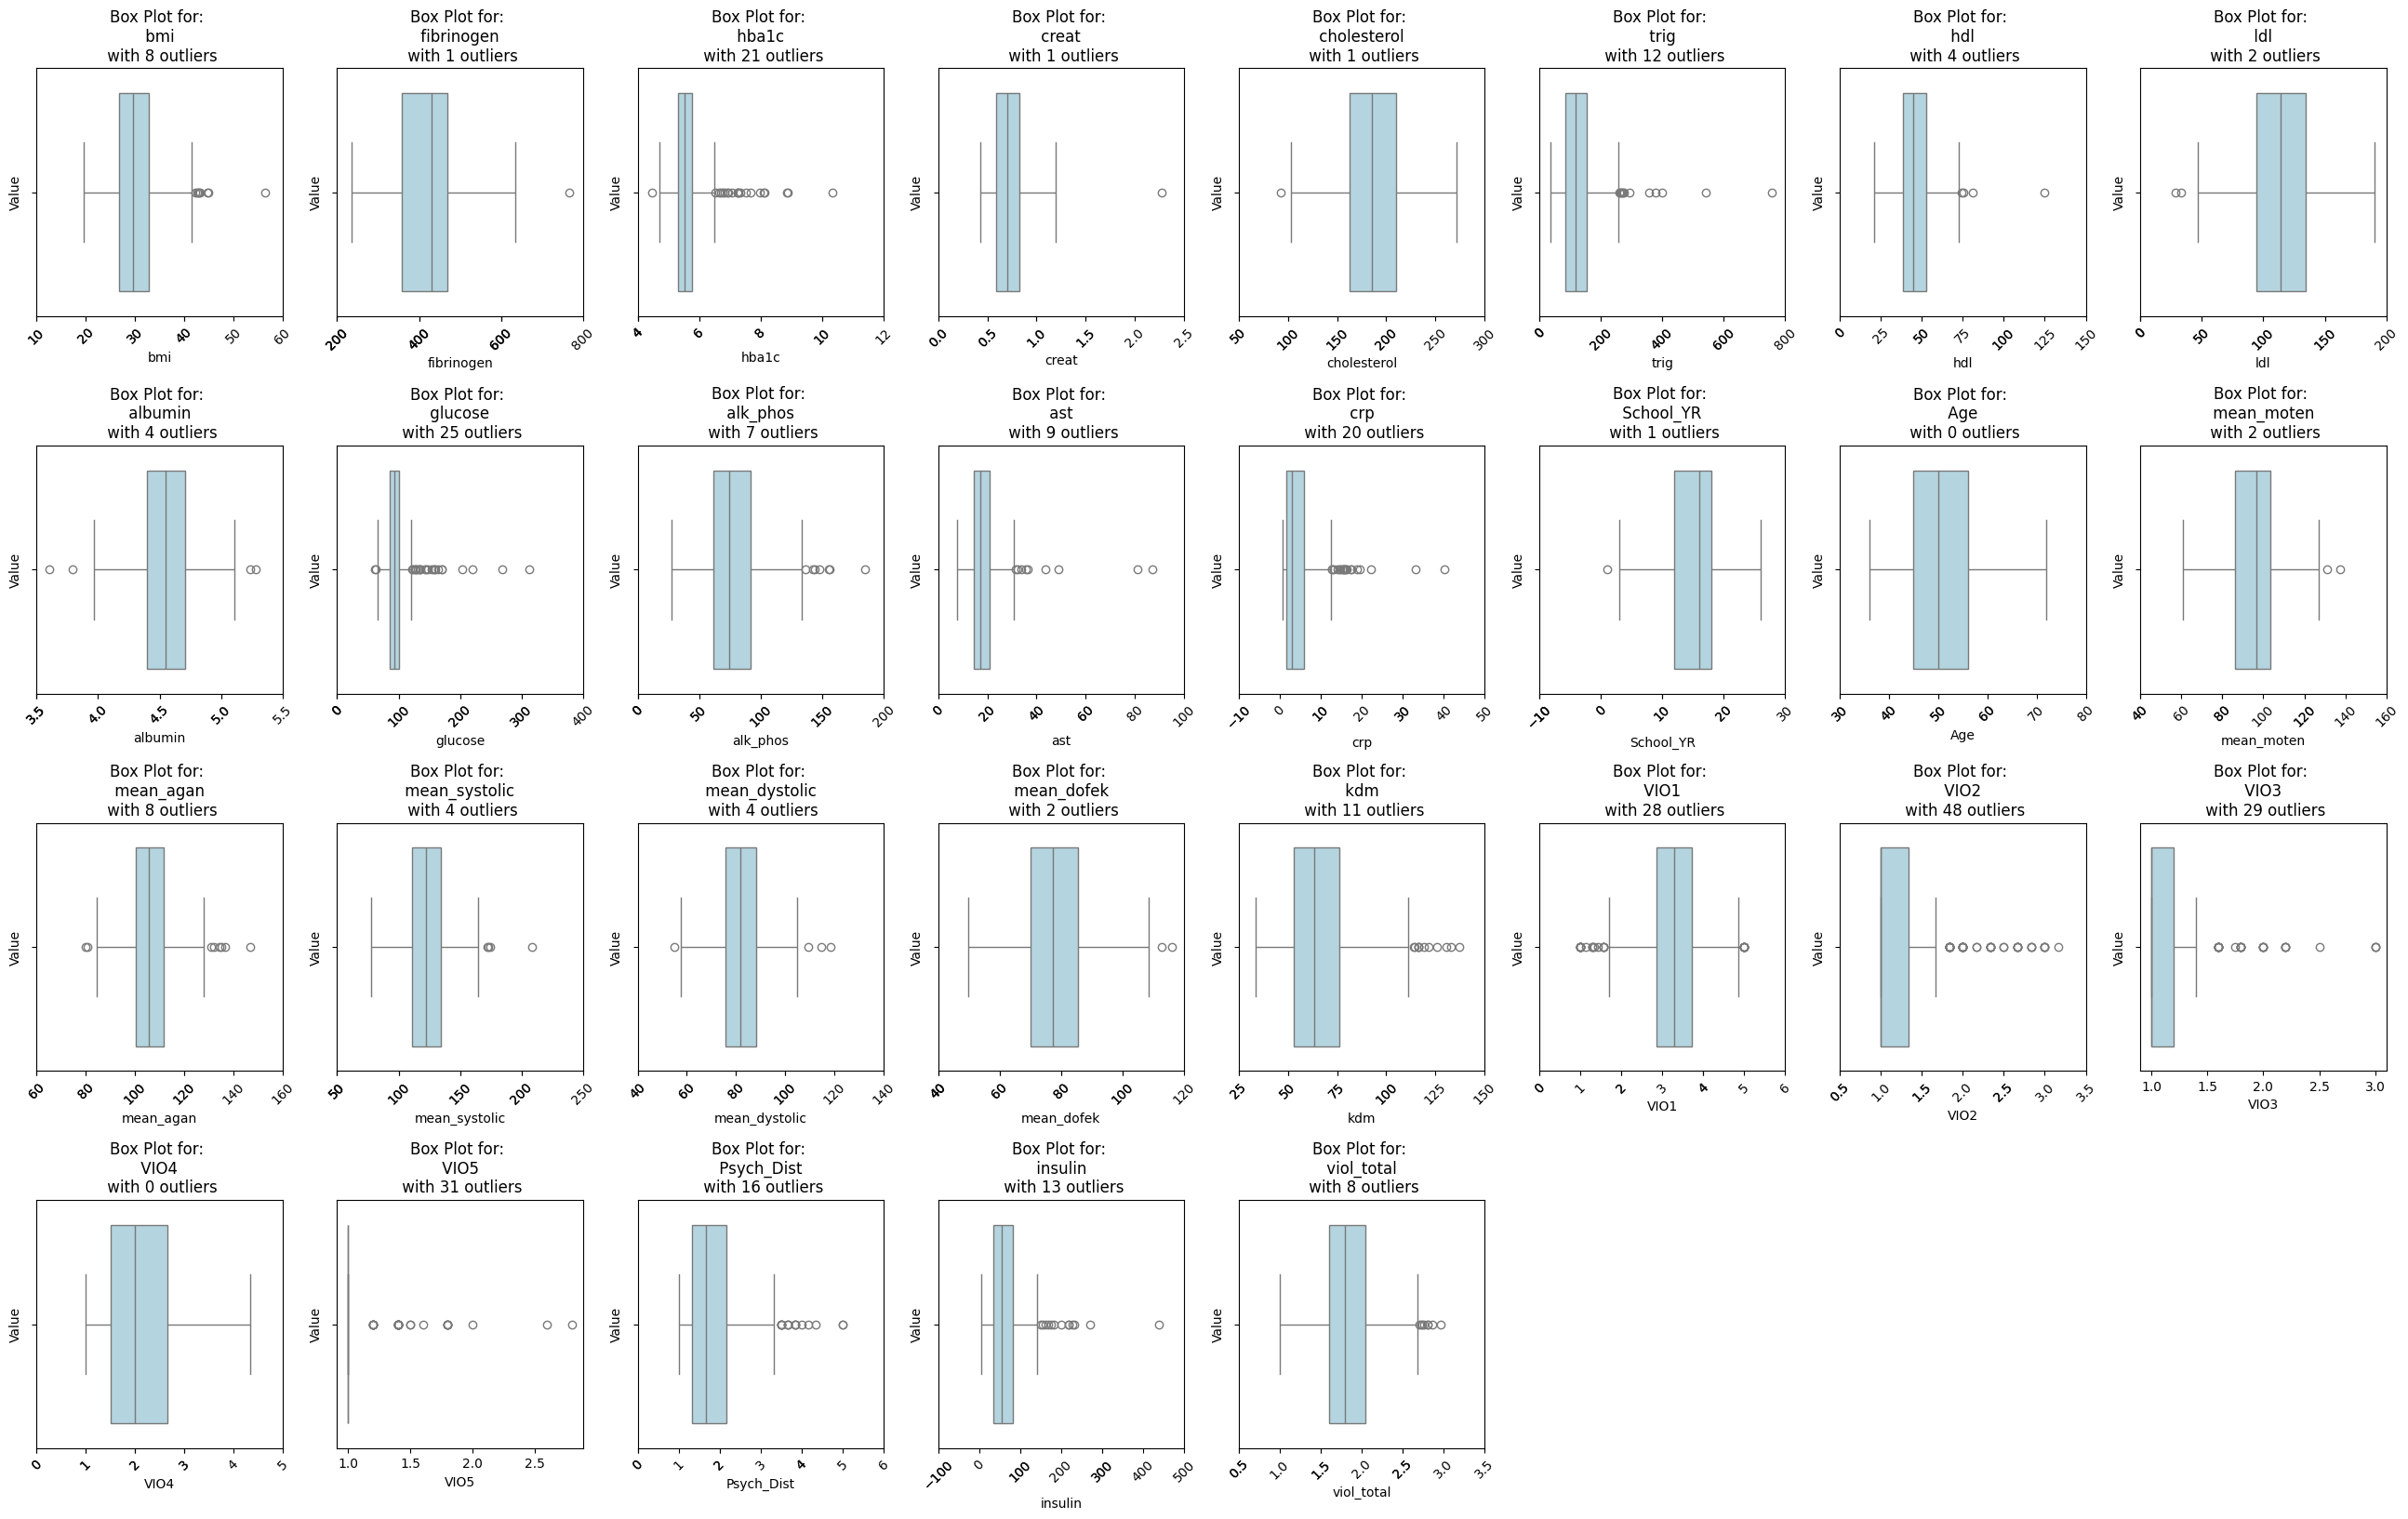

In [ ]:
# Detect outliers using IQR
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return outliers

# Defining columns
columns = numeric_columns

# Number of columns in each row
num_cols_per_row = 8

# Calculate the number of rows needed
num_rows = len(columns) // num_cols_per_row
num_rows += len(columns) % num_cols_per_row

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(26, 4*num_rows))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Threshold for reducing x-ticks
unique_value_threshold = 10

# Iterate through numerical columns and create box plots
for i, column in enumerate(columns):
    outliers_count = len(find_outliers(pd.to_numeric(df_metadata[column], errors='coerce')))

    sns.boxplot(x=df_metadata[column], color='lightblue', ax=axes[i])
    axes[i].set_title(f'Box Plot for: \n {column} \n with {outliers_count} outliers')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')

    # Check the number of unique values
    unique_values = df_metadata[column].nunique()
    # Rotate x-axis labels for better readability
    if unique_values > unique_value_threshold:
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)
        # Reduce the number of x-ticks
        max_xticks = unique_value_threshold
        x_ticks = axes[i].get_xticks()
        reduced_ticks = np.linspace(0, len(x_ticks) - 1, max_xticks, dtype=int)
        axes[i].set_xticks([x_ticks[j] for j in reduced_ticks])

# If there are more subplots than features, turn off the extra subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


# **Features distribution**

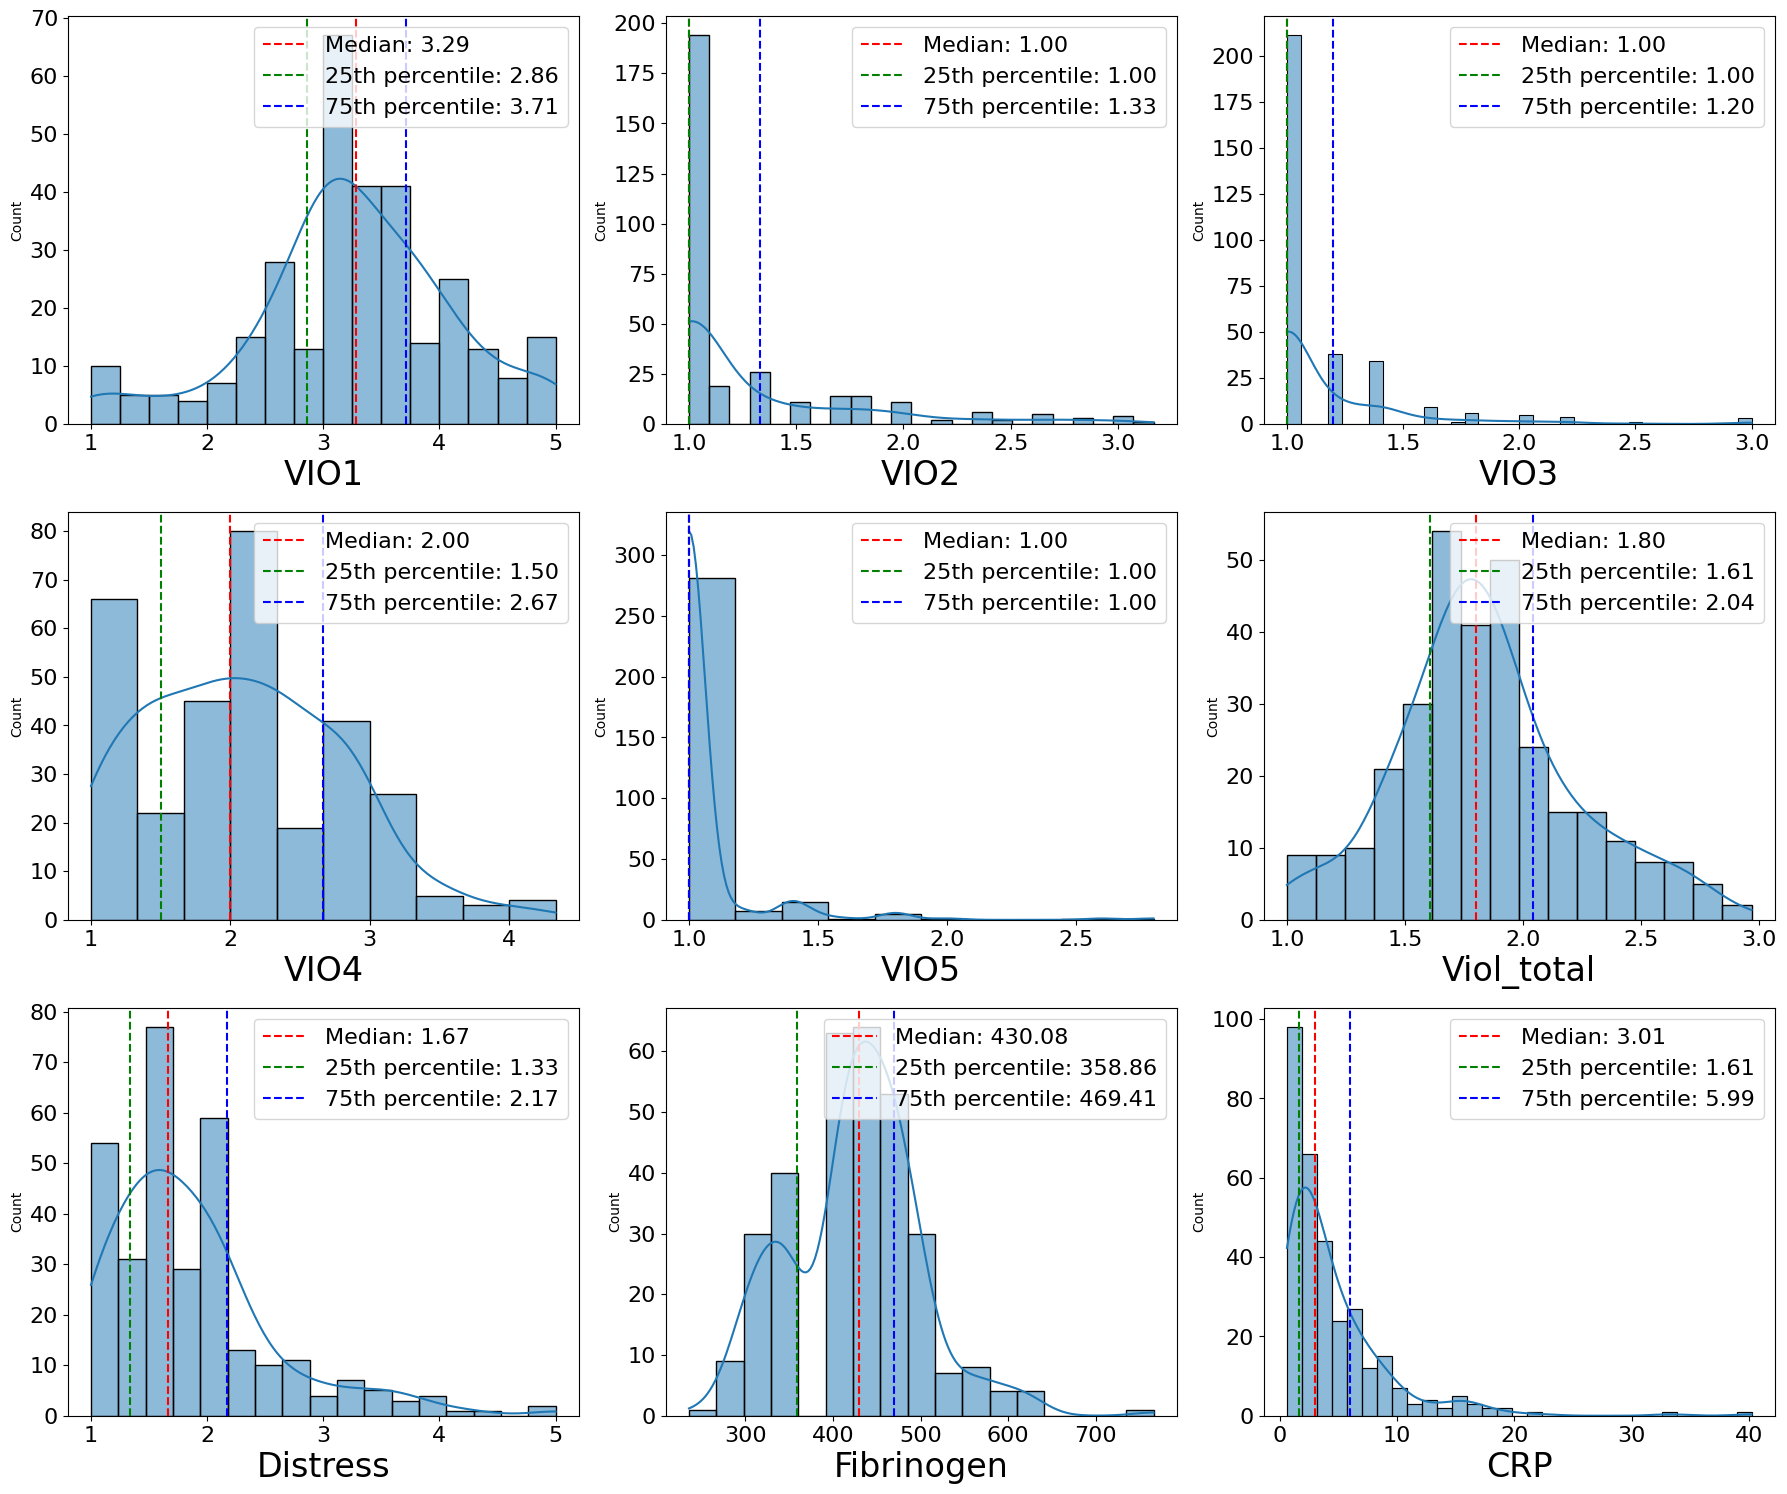

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_distributions(dataframe, features, cols=3):
    # Number of features determines the number of rows and columns in the grid
    nrows = int(np.ceil(len(features) / cols))

    # Create a figure with subplots in a grid defined by nrows and cols
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(cols * 6, nrows * 5))

    # Flatten axes array for easy iteration in case of one row or column
    axes = axes.flatten()

    # Loop through the features and create an area plot for each one
    for i, feature in enumerate(features):
        # Plot the histogram with KDE
        sns.histplot(dataframe[feature], kde=True, ax=axes[i])
        #axes[i].set_title(feature, size=26)
        axes[i].set_xlabel(feature, fontsize=24)
        #axes[i].set_ylabel('Number of patients', fontsize=20)

        # Calculate the median and percentiles
        median = dataframe[feature].median()
        q25 = dataframe[feature].quantile(0.25)
        q75 = dataframe[feature].quantile(0.75)

        # Draw vertical lines for the median and percentiles
        axes[i].axvline(median, color='r', linestyle='--', label=f'Median: {median:.2f}')
        axes[i].axvline(q25, color='g', linestyle='--', label=f'25th percentile: {q25:.2f}')
        axes[i].axvline(q75, color='b', linestyle='--', label=f'75th percentile: {q75:.2f}')
        axes[i].legend(loc='upper right', fontsize=16)

        # Check the number of unique values
        unique_values = dataframe[feature].nunique()
        unique_value_threshold = 10  # Define a threshold for the number of unique values

        # Rotate x-axis labels for better readability
        # if unique_values > unique_value_threshold:
        #     axes[i].tick_params(axis='x', rotation=45, labelsize=20)
        #     axes[i].tick_params(axis='y', labelsize=20)
        #     max_xticks = unique_value_threshold
        #     x_ticks = axes[i].get_xticks()
        #     reduced_ticks = np.linspace(0, len(x_ticks) - 1, max_xticks, dtype=int)
        #     axes[i].set_xticks([x_ticks[j] for j in reduced_ticks])
        # else:
        axes[i].tick_params(axis='x', labelsize=16)
        axes[i].tick_params(axis='y', labelsize=16)

    # If there are more subplots than features, turn off the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    # # Create legend with custom entries
    # handles, labels = axes[i].get_legend_handles_labels()
    # plt.legend(handles=handles, labels=labels, loc='upper right')

    plt.tight_layout()
    plt.show()

selected_features = Target_columns
df_metadata.rename(columns={'crp': 'CRP', 'fibrinogen': 'Fibrinogen', 'viol_total':'Viol_total', 'Psych_Dist':'Distress'}, inplace=True)
selected_features = [ 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'Viol_total', 'Distress', 'Fibrinogen', 'CRP']
plot_feature_distributions(df_metadata, selected_features)



# **Examining Correlations between vio measures, psycho distress, and inflammation measure**

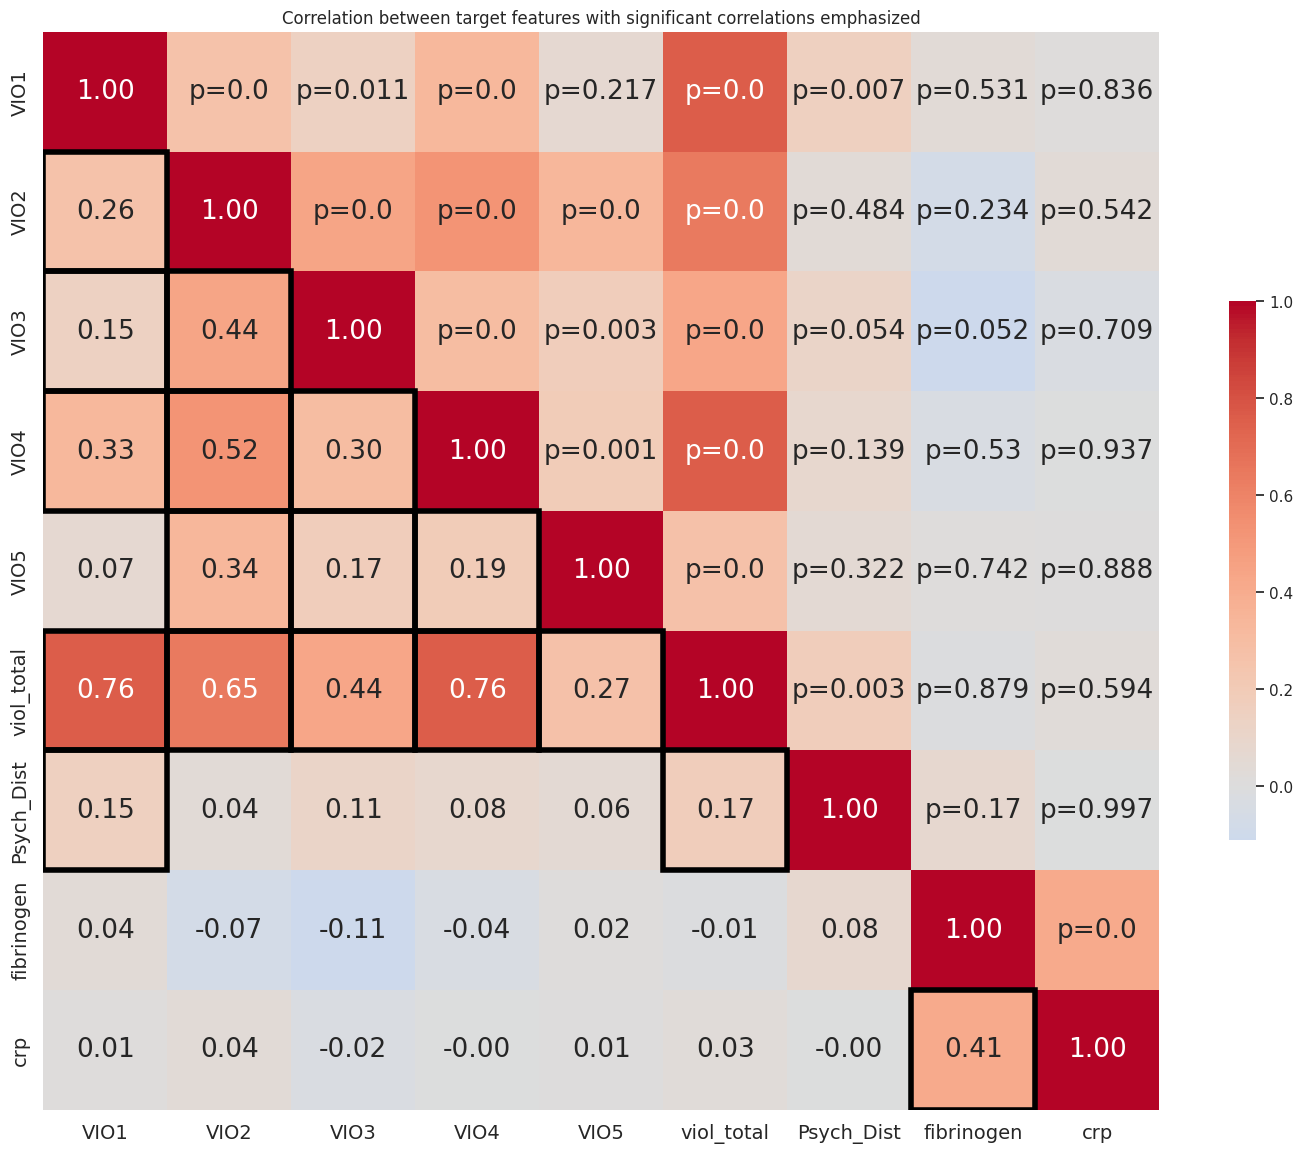

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr


def correlation_matrix(df, Target_columns, corr_method=spearmanr, alpha = 0.05):

    # Initialize correlation and p-values matrix
    corr_matrix = pd.DataFrame(np.full((len(Target_columns), len(Target_columns)), np.nan), columns=Target_columns, index=Target_columns)
    p_values = pd.DataFrame(np.full((len(Target_columns), len(Target_columns)), np.nan), columns=Target_columns, index=Target_columns)

    # Fill correlation and p-values matrix
    for i in range(len(Target_columns)):
        for j in range(len(Target_columns)):
            statistic, p_value = corr_method(df[Target_columns[i]], df[Target_columns[j]])
            corr_matrix.iloc[i, j] = statistic
            p_values.iloc[i, j] = p_value

    # Initialize annotation matrix
    annotations = pd.DataFrame(np.full((len(Target_columns), len(Target_columns)), ''), columns=Target_columns, index=Target_columns)

    # Fill annotations matrix
    for i in range(len(Target_columns)):
        for j in range(len(Target_columns)):
            if i < j:
                annotations.iloc[i, j] = f'p={np.round(p_values.iloc[i, j], 3)}'
            else:
                annotations.iloc[i, j] = f'{corr_matrix.iloc[i, j]:.2f}'

    # Plotting the correlations with p-values in the upper triangle
    plt.figure(figsize=(18, 14))
    heatmap = sns.heatmap(corr_matrix, annot=annotations, fmt='', cmap='coolwarm', center=0, cbar_kws={'shrink': .5}, annot_kws={"size": 19})
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Emphasize significant correlations with a thicker line
    significant_mask = p_values < alpha
    for i in range(len(Target_columns)):
        for j in range(len(Target_columns)):
            if i > j and significant_mask.iloc[i, j]:
                heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=4))

    plt.title('Correlation between target features with significant correlations emphasized')
    plt.show()

########################## Running #############################

# Define parameters
df_metadata = pd.read_csv("metadata.csv")
Target_columns = [ 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'viol_total', 'Psych_Dist', 'fibrinogen', 'crp']

# Drop rows with NaN values in target columns
for target in Target_columns:
    df_metadata[target] = df_metadata[target].apply(lambda x: float(x) if x != ' ' else np.nan)
df_metadata.dropna(subset=Target_columns, inplace=True)
# Drop corresponding rows in data
df_MIPMLP = df_MIPMLP.loc[df_metadata.index]

# Apply correlation matrix
correlation_matrix(df_metadata, Target_columns, corr_method=spearmanr, alpha = 0.05)


# **Detecting interesting interactions**

In [ ]:
# creating histogram of interaction between age, gender, and the target feature
fig = px.histogram(df_metadata[['Age', 'SEX_0M', 'Psych_Dist']].dropna(), x= "Age", y = "Psych_Dist", color = 'SEX_0M',
                  marginal = 'box', title= "Interaction between age, gender, and Psych_Dist")


fig.show()

#**Checking pre-process characteristics:**
1. For each microbe- how many samples are not 0
2. For each sample- how much features are not 0


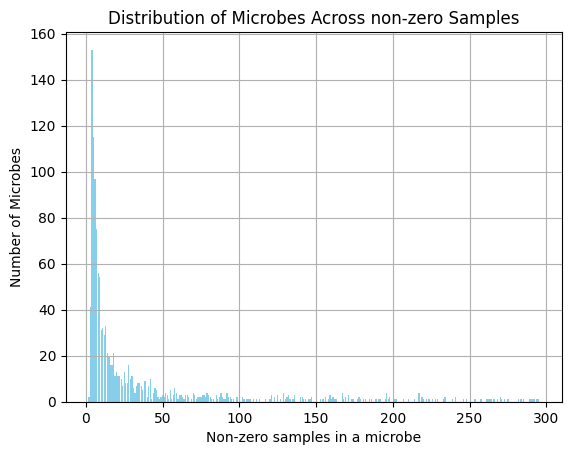

Features with non-zero counts lower than the threshold:
Feature 8: 0
Feature 13: 0
Feature 45: 0
Feature 50: 0
Feature 66: 0
Feature 185: 0
Feature 188: 0
Feature 234: 0
Feature 245: 0
Feature 270: 0
Feature 288: 0
Feature 345: 0
Feature 358: 0
Feature 361: 0
Feature 390: 0
Feature 396: 0
Feature 429: 0
Feature 506: 0
Feature 538: 0
Feature 555: 0
Feature 617: 0
Feature 636: 0
Feature 647: 0
Feature 710: 0
Feature 769: 0
Feature 792: 0
Feature 813: 0
Feature 831: 0
Feature 904: 0
Feature 985: 0
Feature 1013: 24
Feature 1039: 0
Feature 1090: 0
Feature 1118: 0
Feature 1133: 0
Feature 1135: 0
Feature 1141: 0
Feature 1190: 0
Feature 1247: 0
Feature 1260: 0
Feature 1284: 0
Feature 1292: 0
Feature 1294: 0
[55, 67, 104, 122, 148, 193]


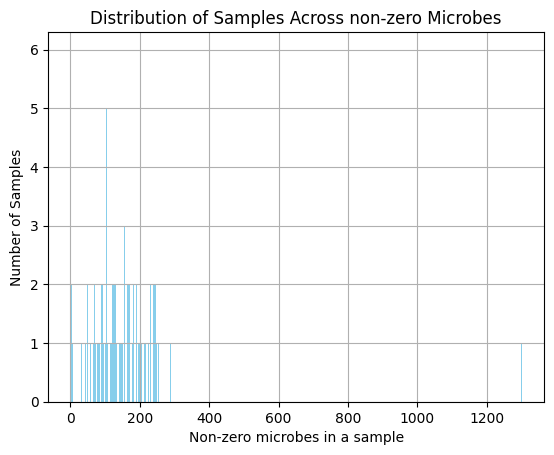

Samples with non-zero counts lower than the threshold:
Sample 55
Sample 67
Sample 104
Sample 122
Sample 148
Sample 193


In [ ]:
# Define parameters
non_zero_treshold = 4 # (10%)


###################################################################################

# 1- For each microbe- how many samples are not 0

# Ensure the DataFrame columns are numeric
last_row = df_preprocess.iloc[-1:]
df_preprocess = df_preprocess.iloc[:-1].apply(pd.to_numeric, errors='coerce')
df_preprocess = pd.concat([df_preprocess, last_row], ignore_index=False)

# # Ensure the DataFrame columns are numeric
# first_column = df_preprocess.iloc[:-1, 0]
# last_row = df_preprocess.iloc[-1:]
# df_preprocess_temp = df_preprocess.iloc[:-1, 1:].apply(pd.to_numeric, errors='coerce')
# df_preprocess_temp = pd.concat([first_column, df_preprocess_temp], axis=1)
# df_preprocess_temp = pd.concat([df_preprocess_temp, last_row], ignore_index=False)
# df_preprocess_temp.iloc[:, 0].name = "ID"
# df_preprocess = df_preprocess_temp

# Count the number of non-zero entries for each column
non_zero_counts_per_col = (df_preprocess != 0).sum(axis=0)
microbe_names = df_preprocess.iloc[-1]
microbe_names_list = microbe_names.values.tolist()

# Extract feature with low count of samples: indices and corresponding feature names
low_count_col_indices = [i for i, count in enumerate(non_zero_counts_per_col) if count < non_zero_treshold]
low_count_features = [microbe_names_list[i] for i in low_count_col_indices]

samples_counts = {}
for count in non_zero_counts_per_col:
    samples_counts.setdefault(count, 0)
    samples_counts[count] += 1

# Plot histogram
plt.bar(samples_counts.keys(), samples_counts.values(), color='skyblue')
plt.xlabel('Non-zero samples in a microbe')
plt.ylabel('Number of Microbes')
plt.title('Distribution of Microbes Across non-zero Samples')
plt.grid(True)
plt.show()

# Print feature names and corresponding indices lower than the threshold
print("Features with non-zero counts lower than the threshold:")
for feature, index in zip(low_count_features, low_count_col_indices):
    print(f"Feature {index}: {feature}")


#########################################################################

# 2- For each sample- how much features are not 0

# Count the number of non-zero features for each sample (row)
non_zero_count_per_row = (df_preprocess.iloc[:, :-1] != 0).sum(axis=1)

# Extract feature with low count of samples: indices and corresponding feature names
low_count_row_indices = [i for i, count in enumerate(non_zero_count_per_row) if count < non_zero_treshold]
print(low_count_row_indices)

features_counts = {}
for count in non_zero_count_per_row:
    features_counts.setdefault(count, 0)
    features_counts[count] += 1

# Plot histogram
plt.bar(features_counts.keys(), features_counts.values(), color='skyblue')
plt.xlabel('Non-zero microbes in a sample')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples Across non-zero Microbes')
plt.grid(True)
plt.show()

# Print samples lower than the threshold
print("Samples with non-zero counts lower than the threshold:")
for sample_index in low_count_row_indices:
    print(f"Sample {sample_index}")


In [ ]:
# Print feature names and amount of samples lower than the threshold
for feature, count in zip(microbe_names_list, non_zero_counts_per_col):
    print(f"Feature: {feature}, Non-zero count: {count}, relative count: {count/df_preprocess.shape[0]}")

Feature: 19, Non-zero count: 36, relative count: 0.11356466876971609
Feature: 0, Non-zero count: 7, relative count: 0.022082018927444796
Feature: 10, Non-zero count: 29, relative count: 0.0914826498422713
Feature: 0, Non-zero count: 10, relative count: 0.031545741324921134
Feature: 134, Non-zero count: 61, relative count: 0.19242902208201892
Feature: 0, Non-zero count: 23, relative count: 0.07255520504731862
Feature: 0, Non-zero count: 5, relative count: 0.015772870662460567
Feature: 49, Non-zero count: 98, relative count: 0.30914826498422715
Feature: 0, Non-zero count: 3, relative count: 0.00946372239747634
Feature: 0, Non-zero count: 28, relative count: 0.08832807570977919
Feature: 0, Non-zero count: 113, relative count: 0.35646687697160884
Feature: 0, Non-zero count: 136, relative count: 0.42902208201892744
Feature: 0, Non-zero count: 7, relative count: 0.022082018927444796
Feature: 0, Non-zero count: 3, relative count: 0.00946372239747634
Feature: 0, Non-zero count: 5, relative cou

In [ ]:
# Print the non-zero features count for each sample
for sample_index, count in enumerate(non_zero_count_per_row):
    print(f"Sample {sample_index}: {count}")

Sample 0: 190
Sample 1: 211
Sample 2: 217
Sample 3: 239
Sample 4: 245
Sample 5: 25
Sample 6: 233
Sample 7: 93
Sample 8: 18
Sample 9: 117
Sample 10: 242
Sample 11: 84
Sample 12: 167
Sample 13: 258
Sample 14: 130
Sample 15: 145
Sample 16: 64
Sample 17: 177
Sample 18: 54
Sample 19: 174
Sample 20: 264
Sample 21: 76
Sample 22: 207
Sample 23: 145
Sample 24: 161
Sample 25: 123
Sample 26: 136
Sample 27: 88
Sample 28: 143
Sample 29: 91
Sample 30: 180
Sample 31: 148
Sample 32: 184
Sample 33: 172
Sample 34: 6
Sample 35: 150
Sample 36: 146
Sample 37: 221
Sample 38: 273
Sample 39: 210
Sample 40: 208
Sample 41: 259
Sample 42: 174
Sample 43: 126
Sample 44: 99
Sample 45: 310
Sample 46: 5
Sample 47: 11
Sample 48: 214
Sample 49: 107
Sample 50: 212
Sample 51: 73
Sample 52: 134
Sample 53: 152
Sample 54: 128
Sample 55: 2
Sample 56: 172
Sample 57: 27
Sample 58: 209
Sample 59: 172
Sample 60: 129
Sample 61: 127
Sample 62: 114
Sample 63: 248
Sample 64: 237
Sample 65: 169
Sample 66: 148
Sample 67: 1
Sample 68: 

# **Checkimg MIPMLP characterisics**

In [ ]:
# Define parameters
threshold = 4 # (10%)
filtered_col_indices = []
filtered_col_names = []

# Iterate through each column
for idx, column in enumerate(df_MIPMLP.columns):
    # Get the most frequent value and its count
    most_frequent_value = df_MIPMLP[column].mode()[0]
    most_frequent_count = (df_MIPMLP[column] == most_frequent_value).sum()
    # Calculate the number of unique values excluding the most frequent one
    unique_values = df_MIPMLP[column].nunique() - 1
    # Check if the unique values count is below the threshold
    if unique_values < threshold:
        filtered_col_indices.append(idx)
        filtered_col_names.append(column)

# Print the results
print("Columns with unique values below the threshold (excluding the most frequent value):")
print("Indices:", filtered_col_indices)
print("Names:", filtered_col_names)


Columns with unique values below the threshold (excluding the most frequent value):
Indices: [7, 23, 41, 64, 65, 79, 135, 139, 152, 164, 172, 179, 185, 205, 207, 208, 209, 215, 216, 217, 221, 226, 234, 236, 238, 239, 241, 242, 244, 245]
Names: ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus_0;s__', 'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;s__stercoris_0', 'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__gordonii_0', 'k__Bacteria;p__Bacteroidetes;c__Cytophagia;o__Cytophagales;f__Cytophagaceae;g__Hymenobacter_0;s__', 'k__Bacteria;p__Bacteroidetes;c__Flavobacteriia;o__Flavobacteriales;f__Flavobacteriaceae;g__Flavobacterium;s__succinicans_0', 'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;s__agilis_0', 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnosp

In [ ]:
# Saving filtered_col_names for invastigation
filtered_col_names = ['k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Mobiluncus_0;s__',
                      'k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Parabacteroides;s__gordonii_0',
                      'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Moryella_0;s__',
                      'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus;s__gauvreauii_0',
                      'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__ph2_0;s__',
                      'k__Bacteria;p__Lentisphaerae;c__[Lentisphaeria];o__Victivallales;f__Victivallaceae;g__Victivallis;s__vadensis_0',
                      'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Caulobacterales;f__Caulobacteraceae;g__Caulobacter;s__henricii_0',
                      'k__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhodobacterales;f__Rhodobacteraceae;g__Paracoccus_0;s__',
                      'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Aggregatibacter;s__segnis_0',
                      'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter_0;s__',
                      'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;s__veronii_0',
                      'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Xanthomonadales;f__Sinobacteraceae_0;g__;s__',
                      'k__Bacteria;p__Synergistetes;c__Synergistia;o__Synergistales;f__Dethiosulfovibrionaceae;g__Pyramidobacter;s__piscolens_0']

# **Drop founded problematic columns and rows**

In [ ]:
# Define parameters
columns_to_drop = filtered_col_names
rows_to_drop = low_count_row_indices
# Drop problematic columns
df_MIPMLP = df_MIPMLP.drop(columns=columns_to_drop)
# Drop problematic rows from MIPMLP and metadata
df_MIPMLP = df_MIPMLP.drop(index=rows_to_drop)
df_MIPMLP_without_z_score = df_MIPMLP_without_z_score.drop(index=rows_to_drop)
df_preprocess = df_preprocess.drop(index=rows_to_drop)
df_preprocess_ID = df_preprocess_ID.drop(index=rows_to_drop)
df_metadata = df_metadata.drop(index=rows_to_drop)
df_MIPMLP_mean = df_MIPMLP_mean.drop(index=rows_to_drop)
df_otu = df_otu.drop(index=rows_to_drop)
# Reset the index after dropping rows
df_MIPMLP.reset_index(drop=True, inplace=True)
df_MIPMLP_without_z_score.reset_index(drop=True, inplace=True)
df_preprocess.reset_index(drop=True, inplace=True)
df_preprocess_ID.reset_index(drop=True, inplace=True)
df_metadata.reset_index(drop=True, inplace=True)
df_MIPMLP_mean.reset_index(drop=True, inplace=True)
df_otu.reset_index(drop=True, inplace=True)

In [ ]:
print(df_MIPMLP.shape)
print(df_MIPMLP_without_z_score.shape)
print(df_preprocess.shape)
print(df_preprocess_ID.shape)
print(df_metadata.shape)
print(df_MIPMLP_mean.shape)
print(df_otu.shape)

(311, 242)
(311, 1302)
(311, 1301)
(312,)
(311, 75)
(311, 255)
(311, 1302)


## **Drop samples absent from targe value**

In [ ]:
df_metadata = df_metadata.dropna(subset=['Psych_Dist'])
df_MIPMLP = df_MIPMLP.loc[df_metadata.index]
df_MIPMLP_without_z_score = df_MIPMLP_without_z_score.loc[df_metadata.index]
df_preprocess = df_preprocess.loc[df_metadata.index]
df_preprocess_ID = df_preprocess_ID.loc[df_metadata.index]
df_MIPMLP_mean = df_MIPMLP_mean.loc[df_metadata.index]
df_otu = df_otu.loc[df_metadata.index]
print(df_MIPMLP.shape)
print(df_preprocess.shape)
print(df_preprocess_ID.shape)
print(df_metadata.shape)
print(df_MIPMLP_mean.shape)
print(df_otu.shape)

(305, 242)
(305, 1301)
(305,)
(305, 75)
(305, 255)
(305, 1302)


In [ ]:
# Define parameters
threshold = 4 # (10%)
filtered_col_indices = []
filtered_col_names = []

# Iterate through each column
for idx, column in enumerate(df_MIPMLP_without_z_score.columns):
    # Get the most frequent value and its count
    most_frequent_value = df_MIPMLP_without_z_score[column].mode()[0]
    most_frequent_count = (df_MIPMLP_without_z_score[column] == most_frequent_value).sum()
    # Calculate the number of unique values excluding the most frequent one
    unique_values = df_MIPMLP_without_z_score[column].nunique() - 1
    # Check if the unique values count is below the threshold
    if unique_values < threshold:
        filtered_col_indices.append(idx)
        filtered_col_names.append(column)

# Print the results
print("Columns with unique values below the threshold (excluding the most frequent value):")
print("Indices:", filtered_col_indices)
print("Names:", filtered_col_names)

df_MIPMLP_without_z_score = df_MIPMLP_without_z_score.drop(columns=filtered_col_names)

df_MIPMLP_without_z_score.to_csv("MIPMLP_format_filtered.csv")

Columns with unique values below the threshold (excluding the most frequent value):
Indices: [9, 14, 15, 19, 21, 31, 39, 45, 46, 51, 58, 67, 82, 85, 88, 96, 97, 100, 113, 118, 122, 142, 147, 148, 151, 155, 158, 160, 164, 166, 168, 176, 180, 181, 186, 189, 197, 206, 221, 225, 228, 229, 231, 234, 235, 236, 238, 240, 244, 246, 250, 252, 254, 260, 268, 271, 274, 288, 289, 300, 302, 306, 311, 321, 337, 338, 341, 346, 359, 362, 366, 368, 371, 373, 375, 380, 381, 390, 391, 393, 397, 398, 399, 401, 403, 404, 416, 418, 419, 428, 430, 432, 435, 440, 447, 450, 458, 465, 475, 483, 488, 507, 523, 526, 532, 534, 539, 542, 543, 544, 546, 550, 556, 557, 559, 564, 577, 585, 594, 595, 596, 597, 598, 611, 615, 616, 617, 618, 620, 624, 630, 636, 637, 640, 645, 648, 656, 657, 659, 661, 667, 686, 710, 711, 712, 718, 724, 725, 735, 757, 759, 764, 765, 766, 770, 781, 793, 805, 814, 815, 822, 823, 826, 830, 831, 832, 839, 841, 845, 846, 852, 860, 870, 872, 876, 880, 887, 892, 899, 905, 907, 912, 919, 935, 940,

# **Demographic**

## Groups size

In [ ]:
threshold = 1.833
target = 'Psych_Dist'

# Calculate the number of values lower than threshold
lower_group_size = df_metadata[df_metadata[target] < threshold].shape[0]

# Calculate the number of values not lower than threshold
higher_group_size = df_metadata[df_metadata[target] >= threshold].shape[0]

# Print the results
print(f'Number of values lower than {threshold}: {lower_group_size}')
print(f'Number of values not lower than {threshold}: {higher_group_size}')

Number of values lower than 1.833: 151
Number of values not lower than 1.833: 142


## Male precentage

In [ ]:
from scipy.stats import chi2_contingency

threshold = 1.833

# Total population
total_males = df_metadata[df_metadata['SEX_0M'] == 0].shape[0]
total_population = 305
percent_males_total = (total_males / total_population) * 100

# Lower than threshold
lower_group = df_metadata[df_metadata['Psych_Dist'] < threshold]
lower_males = lower_group[lower_group['SEX_0M'] == 0].shape[0]
percent_males_lower = (lower_males / lower_group.shape[0]) * 100

# Higher or equal to threshold
higher_group = df_metadata[df_metadata['Psych_Dist'] >= threshold]
higher_males = higher_group[higher_group['SEX_0M'] == 0].shape[0]
percent_males_higher = (higher_males / higher_group.shape[0]) * 100

# Print the results
print(f'Percentage of males in total population: {percent_males_total:.2f}%')
print(f'Percentage of males in group with psyh_distress lower than {threshold}: {percent_males_lower:.2f}%')
print(f'Percentage of males in group with psyh_distress higher or equal to {threshold}: {percent_males_higher:.2f}%')

# Chi-square test of independence
contingency_table = [[lower_males, lower_group_size - lower_males],
                     [higher_males, higher_group_size - higher_males]]

chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a significant difference in the proportion of males between the two groups.")
else:
    print("There is no significant difference in the proportion of males between the two groups.")

Percentage of males in total population: 38.36%
Percentage of males in group with psyh_distress lower than 1.833: 43.05%
Percentage of males in group with psyh_distress higher or equal to 1.833: 36.62%
Chi-square statistic: 1.01
P-value: 0.3158
There is no significant difference in the proportion of males between the two groups.


In [ ]:
from scipy.stats import mannwhitneyu, ttest_ind

threshold = 1.833

# List of features to calculate the 25th-75th percentile
features = ['viol_total', 'Psych_Dist', 'Age', 'bmi', 'fibrinogen', 'crp', 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5']

# Function to calculate and print the 25th-75th percentile for each feature in a given group
def print_percentiles(group, group_name):
    print(f'\n25th-75th percentiles for {group_name}:')
    for feature in features:
        q25 = group[feature].quantile(0.25)
        median = group[feature].median()
        q75 = group[feature].quantile(0.75)
        mean = group[feature].mean()
        std = group[feature].std()
        print(f'{feature}: {q25:.2f} - {median:.2f} - {q75:.2f}, (mean: {mean:.2f}, std: {std:.2f})')

# Function to perform statistical tests
def perform_statistical_test(feature, lower_group, higher_group):

    # Remove rows with NaN values for the feature
    lower_group_nonan = lower_group.dropna(subset=[feature])
    higher_group_nonan = higher_group.dropna(subset=[feature])

    if feature in ['viol_total', 'VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'Psych_Dist', 'fibrinogen', 'crp']:
        # Mann-Whitney U test
        if len(lower_group_nonan[feature]) > 0 and len(higher_group_nonan[feature]) > 0:
            stat, p_value = mannwhitneyu(lower_group_nonan[feature], higher_group_nonan[feature])
        else:
            stat, p_value = float('nan'), float('nan')
        test_name = 'Mann-Whitney U'
    else:
        # Independent samples t-test
        if len(lower_group_nonan[feature]) > 0 and len(higher_group_nonan[feature]) > 0:
            stat, p_value = ttest_ind(lower_group_nonan[feature], higher_group_nonan[feature])
        else:
            stat, p_value = float('nan'), float('nan')
        test_name = 'Independent Samples t-test'

    return test_name, stat, p_value

# Calculate and print the 25th-75th percentiles for each group
print_percentiles(df_metadata, 'total population')
print_percentiles(lower_group, 'group with Psych_Dist lower than 1.833')
print_percentiles(higher_group, 'group with Psych_Dist higher or equal to 1.833')

# Perform statistical tests for each feature
for feature in features:
    test_name, stat, p_value = perform_statistical_test(feature, lower_group, higher_group)
    print(f"\n{feature} ({test_name})")
    print(f"Statistic: {stat:.2f}")
    print(f"P-value: {p_value:.4f}")
    if p_value < 0.05:
        print("There is a significant difference between the groups.")
    else:
        print("There is no significant difference between the groups.")



25th-75th percentiles for total population:
viol_total: 1.63 - 1.80 - 2.07, (mean: 1.85, std: 0.38)
Psych_Dist: 1.33 - 1.67 - 2.17, (mean: 1.88, std: 0.72)
Age: 45.00 - 50.00 - 56.00, (mean: 50.90, std: 6.98)
bmi: 26.86 - 29.58 - 32.60, (mean: 30.13, std: 4.92)
fibrinogen: 401.69 - 430.50 - 469.64, (mean: 426.89, std: 74.67)
crp: 1.61 - 2.98 - 5.87, (mean: 4.59, std: 4.81)
VIO1: 2.86 - 3.29 - 3.86, (mean: 3.26, std: 0.86)
VIO2: 1.00 - 1.00 - 1.33, (mean: 1.28, std: 0.48)
VIO3: 1.00 - 1.00 - 1.20, (mean: 1.16, std: 0.32)
VIO4: 1.50 - 2.00 - 2.67, (mean: 2.09, std: 0.70)
VIO5: 1.00 - 1.00 - 1.00, (mean: 1.05, std: 0.19)

25th-75th percentiles for group with Psych_Dist lower than 1.833:
viol_total: 1.53 - 1.73 - 2.00, (mean: 1.79, std: 0.40)
Psych_Dist: 1.17 - 1.33 - 1.50, (mean: 1.37, std: 0.24)
Age: 46.00 - 50.00 - 57.00, (mean: 51.51, std: 7.06)
bmi: 26.83 - 29.41 - 32.20, (mean: 29.80, std: 4.54)
fibrinogen: 355.86 - 422.80 - 470.34, (mean: 423.10, std: 79.23)
crp: 1.67 - 2.96 - 5.78

# **Diversity**

## Alpha diversity

In [ ]:
import skbio.diversity.alpha as alpha
import skbio.diversity.beta as beta
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
from scipy.stats import entropy

df_MIPMLP_mean = df_MIPMLP_mean.apply(pd.to_numeric, errors='coerce')
df_otu = df_otu.apply(pd.to_numeric, errors='coerce')

# Calculate Alpha Diversity
species_richness = df_MIPMLP_mean.apply(lambda x: x.gt(0).sum(), axis=1)
shannon_diversity = df_MIPMLP_mean.apply(lambda x: entropy(x[x > 0]), axis=1)

#simpson_diversity = df_MIPMLP_mean.apply(lambda x: 1 - sum((x / sum(x)) ** 2), axis=1)
print(species_richness)
print(shannon_diversity)

#print(simpson_diversity)
df_MIPMLP['species_richness'] = species_richness.values
df_MIPMLP['shannon_diversity'] = shannon_diversity.values

#df_MIPMLP['simpson_diversity'] = simpson_diversity.values
df_MIPMLP.to_csv("MIPMLP_with_alpha_diversity_8.csv", index=False)

0      72
1      82
2      83
3      79
4      83
       ..
306    57
307    47
308    42
309    85
310    76
Length: 305, dtype: int64
0      2.684047
1      2.105278
2      2.968092
3      3.153568
4      3.226873
         ...   
306    2.262991
307    2.961603
308    2.204793
309    3.173149
310    2.576549
Length: 305, dtype: float64


## Beta diversity

Distress

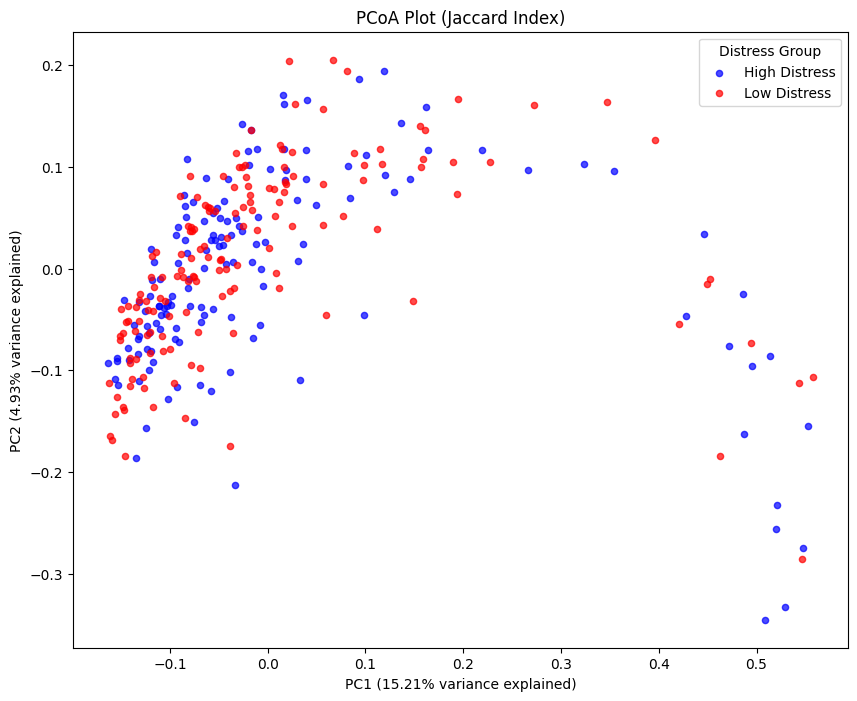

PermANOVA result for Jaccard distance matrix:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     299
number of groups                  2
test statistic             0.928219
p-value                       0.532
number of permutations          999
Name: PERMANOVA results, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova

# Define the distress threshold and classify the samples
threshold = 1.833
target = 'Psych_Dist'
target_binary = "Psych_Dist_Binary"
df_metadata[target_binary] = pd.to_numeric(df_metadata[target], errors='coerce')
df_metadata[target_binary] = np.where(df_metadata[target] < threshold, 'Low Distress', 'High Distress')

# # Calculate Bray-Curtis Dissimilarity Matrix
# braycurtis_matrix = beta_diversity(metric='braycurtis', counts=df_MIPMLP_mean.values, ids=df_MIPMLP_mean.index)

# # Handle NaNs and Infs in the Bray-Curtis Dissimilarity Matrix
# braycurtis_matrix_data = braycurtis_matrix.data
# braycurtis_matrix_data[np.isnan(braycurtis_matrix_data)] = np.nanmax(braycurtis_matrix_data[~np.isnan(braycurtis_matrix_data)])
# braycurtis_matrix_data[np.isinf(braycurtis_matrix_data)] = np.nanmax(braycurtis_matrix_data[~np.isinf(braycurtis_matrix_data)])

# # Perform PCoA
# pcoa_results = pcoa(braycurtis_matrix)

# Plot the PCoA Results
def plot_pcoa(pcoa_results, metadata, title="PCoA Plot"):
    fig, ax = plt.subplots(figsize=(10, 8))
    # Extract PC1 and PC2
    pc1 = pcoa_results.samples['PC1']
    pc2 = pcoa_results.samples['PC2']

    # Scatter plot of the PCoA results with colors based on distress groups
    unique_groups = metadata[target_binary].unique()
    colors = ['blue', 'red']
    for group, color in zip(unique_groups, colors):
        group_indices = metadata[target_binary] == group
        ax.scatter(pc1[group_indices], pc2[group_indices], c=color, label=group, s=20, alpha=0.7)

    # Add axis labels and title
    ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}% variance explained)")
    ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}% variance explained)")
    ax.set_title(title)

    # Add a legend
    ax.legend(title='Distress Group')

    plt.show()

# # Plot the PCoA results for Bray-Curtis with metadata
# plot_pcoa(pcoa_results, df_metadata, title="PCoA Plot (Bray-Curtis Dissimilarity)")

# Calculate Jaccard Index Distance Matrix
jaccard_matrix = beta_diversity(metric='jaccard', counts=df_MIPMLP_mean.values, ids=df_MIPMLP_mean.index)

# Handle NaNs and Infs in the Jaccard Index Distance Matrix
jaccard_matrix_data = jaccard_matrix.data
jaccard_matrix_data[np.isnan(jaccard_matrix_data)] = np.nanmax(jaccard_matrix_data[~np.isnan(jaccard_matrix_data)])
jaccard_matrix_data[np.isinf(jaccard_matrix_data)] = np.nanmax(jaccard_matrix_data[~np.isinf(jaccard_matrix_data)])

# Perform PCoA
pcoa_results_jaccard = pcoa(jaccard_matrix)

# Plot the PCoA Results for Jaccard with metadata
plot_pcoa(pcoa_results_jaccard, df_metadata, title="PCoA Plot (Jaccard Index)")

# Perform PermANOVA on Jaccard Distance Matrix
# Convert categorical distress groups to numeric
df_metadata[target_binary] = df_metadata[target_binary].map({'Low Distress': 0, 'High Distress': 1})
grouping_factor_jaccard = df_metadata[target_binary]
permanova_result_jaccard = permanova(jaccard_matrix, grouping_factor_jaccard)
print("PermANOVA result for Jaccard distance matrix:")
print(permanova_result_jaccard)


Violence

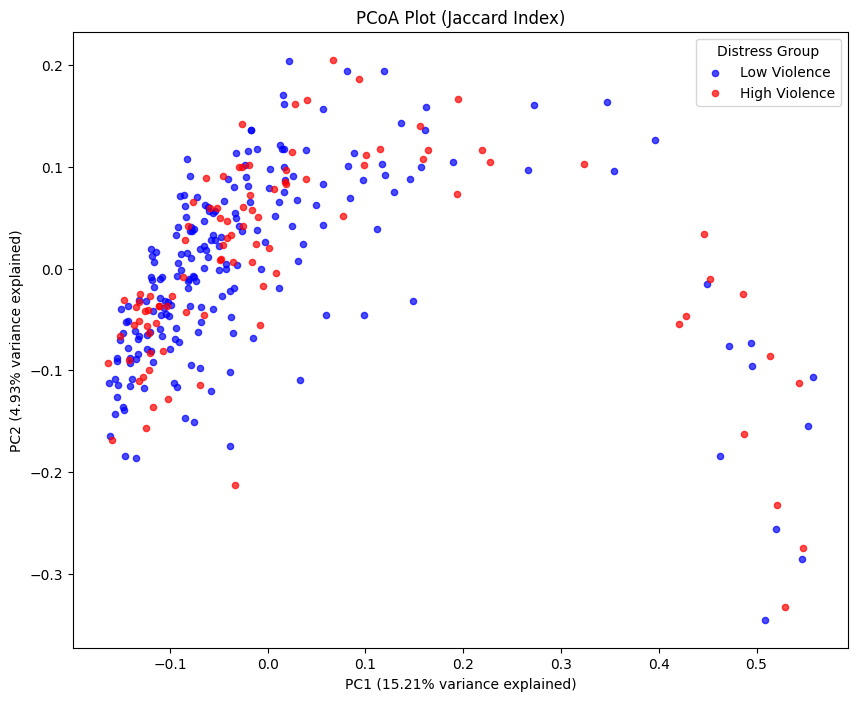

PermANOVA result for Jaccard distance matrix:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     299
number of groups                  2
test statistic             1.361045
p-value                       0.078
number of permutations          999
Name: PERMANOVA results, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova

# Define the violence threshold and classify the samples
target = 'VIO3'
target_binary = "viol_total_Binary"
threshold = np.mean(df_metadata[target])
df_metadata[target_binary] = pd.to_numeric(df_metadata[target], errors='coerce')
df_metadata[target_binary] = np.where(df_metadata[target] < threshold, 'Low Violence', 'High Violence')

# Plot the PCoA Results
def plot_pcoa(pcoa_results, metadata, title="PCoA Plot"):
    fig, ax = plt.subplots(figsize=(10, 8))
    # Extract PC1 and PC2
    pc1 = pcoa_results.samples['PC1']
    pc2 = pcoa_results.samples['PC2']

    # Scatter plot of the PCoA results with colors based on distress groups
    unique_groups = metadata[target_binary].unique()
    colors = ['blue', 'red']
    for group, color in zip(unique_groups, colors):
        group_indices = metadata[target_binary] == group
        ax.scatter(pc1[group_indices], pc2[group_indices], c=color, label=group, s=20, alpha=0.7)

    # Add axis labels and title
    ax.set_xlabel(f"PC1 ({pcoa_results.proportion_explained[0]*100:.2f}% variance explained)")
    ax.set_ylabel(f"PC2 ({pcoa_results.proportion_explained[1]*100:.2f}% variance explained)")
    ax.set_title(title)

    # Add a legend
    ax.legend(title='Distress Group')

    plt.show()

# # Plot the PCoA results for Bray-Curtis with metadata
# plot_pcoa(pcoa_results, df_metadata, title="PCoA Plot (Bray-Curtis Dissimilarity)")

# Calculate Jaccard Index Distance Matrix
jaccard_matrix = beta_diversity(metric='jaccard', counts=df_MIPMLP_mean.values, ids=df_MIPMLP_mean.index)

# Handle NaNs and Infs in the Jaccard Index Distance Matrix
jaccard_matrix_data = jaccard_matrix.data
jaccard_matrix_data[np.isnan(jaccard_matrix_data)] = np.nanmax(jaccard_matrix_data[~np.isnan(jaccard_matrix_data)])
jaccard_matrix_data[np.isinf(jaccard_matrix_data)] = np.nanmax(jaccard_matrix_data[~np.isinf(jaccard_matrix_data)])

# Perform PCoA
pcoa_results_jaccard = pcoa(jaccard_matrix)

# Plot the PCoA Results for Jaccard with metadata
plot_pcoa(pcoa_results_jaccard, df_metadata, title="PCoA Plot (Jaccard Index)")

# Perform PermANOVA on Jaccard Distance Matrix
# Convert categorical distress groups to numeric
df_metadata[target_binary] = df_metadata[target_binary].map({'Low Violence': 0, 'High Violence': 1})
grouping_factor_jaccard = df_metadata[target_binary]
permanova_result_jaccard = permanova(jaccard_matrix, grouping_factor_jaccard)
print("PermANOVA result for Jaccard distance matrix:")
print(permanova_result_jaccard)

## **Correlations cheking**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, pearsonr, spearmanr
from statsmodels.stats.multitest import multipletests

projects_list = ["Distress_new"]
targets = ['VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'viol_total', 'Psych_Dist']
cor_method = spearmanr #mannwhitneyu, pearsonr, spearmanr
alpha = 0.05

for project in projects_list:

    # printing the project name and time
    print(f"\nProject: {project}")

    # Drop rows with NaN values in target columns
    for target in targets:
        df_metadata[target] = df_metadata[target].apply(lambda x: float(x) if x != ' ' else np.nan)
    df_metadata.dropna(subset=targets, inplace=True)
    # Drop corresponding rows in data
    df_MIPMLP = df_MIPMLP.loc[df_metadata.index]

    # Define colums names
    bacteria_names = df_MIPMLP.columns[1:]

    # Apply correlation test
    for target in targets:

        print(f"\nProject: {project}, Target: {target}")

        # calculate the spearman p-values for all bacteria features
        correlations = []
        p_values = []
        for bacteria in bacteria_names:
            statistic, p_value = cor_method(df_MIPMLP[bacteria], df_metadata[target])
            correlations.append(statistic)
            p_values.append(p_value)
            if p_value < alpha:
               direction = "positive" if statistic > 0 else "negative"
               print(f"Bacteria: {bacteria}, Correlation: {statistic}, Direction: {direction}, p-value: {p_value}")

        print(f"\nBenjamini-Hochberg adjusted p-values for Project: {project}, Target: {target}")

        # calculate the Benjamini-Hochberg adjusted p-values for all bacteria features
        _, adjusted_p_values, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
        sorted_indices = sorted(range(len(adjusted_p_values)), key=lambda x: adjusted_p_values[x])

        flag = 0
        for idx in sorted_indices:
            if adjusted_p_values[idx] < alpha:
                bacteria = bacteria_names[idx]
                statistic = correlations[idx]
                direction = "positive" if statistic > 0 else "negative"
                adj_p_value = adjusted_p_values[idx]
                print(f"Bacteria: {bacteria}, Correlation: {statistic}, Direction: {direction}, Adjusted p-value: {adj_p_value}")
                flag = 1
        if flag == 0:
            print(" * No significant bacteria was discovered *\n\n\n")


Project: Distress_new

Project: Distress_new, Target: VIO1
Bacteria: k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__alactolyticus_0, Correlation: 0.12927653182074136, Direction: positive, p-value: 0.025389442589437615
Bacteria: k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Eubacteriaceae;g__Anaerofustis_0;s__, Correlation: 0.12020298155772889, Direction: positive, p-value: 0.03777061359157861
Bacteria: k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Butyrivibrio_0;s__, Correlation: 0.11573729983436006, Direction: positive, p-value: 0.04554057462158866
Bacteria: k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__[Tissierellaceae];g__Finegoldia_0;s__, Correlation: -0.1214308846244797, Direction: negative, p-value: 0.035842161435212086
Bacteria: k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__[Eubacterium];s__cylindroides_0, Correlation: -0.1

# **Performing regression model**

---



### Analyse

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from statsmodels.stats.multitest import multipletests

def return_leaf_names(bacteria_names):

    # Identify non-leaf taxa (those that are prefixes of longer taxa)
    non_leaf_taxa = set()
    for name in bacteria_names:
        parts = name.split(";")
        for i in range(1, len(parts)):
            parent = ";".join(parts[:i])
            non_leaf_taxa.add(parent)

    # Filter out non-leaf names (i.e. keep only real leaves)
    leaf_names = [name for name in bacteria_names if name not in non_leaf_taxa]

    return leaf_names

def Extract_mirobes_names(MIPMLP, Name_list):

    microbes_list = []
    for name in Name_list:
        microbes_list += [col for col in MIPMLP.columns if name in col]

    return list(set(microbes_list))

def analyze_microbes(df_metadata, df_MIPMLP, df_MIPMLP_mean, targets, independent_vars, numeric_features, binary_features):
    from sklearn.impute import SimpleImputer
    from scipy.stats import iqr
    import statsmodels.api as sm
    from statsmodels.stats.multitest import multipletests
    import pandas as pd

    # pre-process data
    for col in numeric_columns:
        df_metadata[col] = pd.to_numeric(df_metadata[col], errors='coerce')

    # Preprocess numeric
    numeric_imputer = SimpleImputer(strategy='median')
    df_metadata[numeric_features] = numeric_imputer.fit_transform(df_metadata[numeric_features])

    # Preprocess binary
    binary_imputer = SimpleImputer(strategy='most_frequent')
    df_metadata[binary_features] = binary_imputer.fit_transform(df_metadata[binary_features])

    # Store results
    results = []

    for target in targets:
        # Drop rows with NaN values in the target column
        df_metadata = df_metadata.dropna(subset=[target])
        # Align the microbiome data with the cleaned metadata
        df_MIPMLP = df_MIPMLP.loc[df_metadata.index]
        df_MIPMLP_mean = df_MIPMLP_mean.loc[df_metadata.index]
        y = df_metadata[target]

        for microbe in df_MIPMLP.columns:
            X = df_metadata[independent_vars].copy()
            X['microbe'] = df_MIPMLP[microbe]
            X = sm.add_constant(X)

            try:
                model = sm.OLS(y.astype(float), X.astype(float)).fit()

                if 'microbe' in model.pvalues:  # and model.pvalues['microbe'] < 0.05:
                    results.append({
                        'Microbe': microbe,
                        'Target': target,
                        'Beta': model.params['microbe'],
                        'p-value': model.pvalues['microbe'],
                        'N': len(y),
                        'Model': 'OLS'
                    })
            except Exception as e:
                print(f"Model failed for {microbe} and {target}: {e}")

    if results:
        results_df = pd.DataFrame(results)
        results_df['q-value'] = multipletests(results_df['p-value'], method='fdr_bh')[1]
        results_df.to_csv("Microbes_with_statistics.csv", index=False)
    else:
        print("No significant microbes were found.")



##############################################################################################

# Define target values and independent variables
targets = ['VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5', 'viol_total', 'Psych_Dist']
independent_vars = ['bmi', 'Age', 'SEX_0M']
numeric_features = ['bmi', 'Age']
binary_features = ['SEX_0M']
Literature_genus = ['Lactobacillus', 'plantarum', 'Parabacteroides', 'goldsteinii', 'Barnesiella', 'intestinihominis',
                     'Paraprevotella','Eubacterium', 'eligens', 'distasonis', 'Akkermansia', 'muciniphila',
                     'Bacteroides', 'massiliensis', 'Bifidobacterium', 'longum', 'Dialister', 'invisus','Roseburia',
                     'inulinivorans', 'Streptococcus','Acidameinococcus', 'Pilipacter', 'Lutispora', 'Proteiniclasticum',
                     'Thermodesulfobium', 'Ruminococcus', 'Anaerostipes', 'Clostridium', 'XIVa', 'Eisenbergiella',
                     'Lachnospira', 'Pseudoflavonifractor', 'Subdoligranulum', 'ramosum', 'Collinsella', 'Veillonella',
                     'Bifidocaterium', 'Gemmiger', 'Lactococcus', 'SMB53', 'Firmicutes', 'Tenericutes', 'coprostanoligenes',
                     'Ruminococcaceae' 'UCG-014', 'Prevotella', 'Shigella', 'Escherichia', 'Fusobacterium', 'gnavus']

df_MIPMLP = df_MIPMLP.iloc[:,1:]
df_MIPMLP_mean = df_MIPMLP_mean.iloc[:,1:]
df_metadata = df_metadata.iloc[:,1:]


#Filter dfs to contain only leaf
leaf_cols = return_leaf_names(df_MIPMLP.columns)
df_MIPMLP = df_MIPMLP[leaf_cols]
microbe_literature_overlap_list = Extract_mirobes_names(df_MIPMLP, list(set(Literature_genus)))
df_MIPMLP = df_MIPMLP[microbe_literature_overlap_list]

df_MIPMLP.to_csv("MIPMLP_filtered.csv")

analyze_microbes(df_metadata, df_MIPMLP, df_MIPMLP_mean, targets, independent_vars, numeric_features, binary_features)


### Visualization

In [ ]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

results_df = pd.read_csv("Microbes_with_statistics_CCA.csv")
results_df['q-value'] = multipletests(results_df['p-value'], method='fdr_bh')[1]
results_df.to_csv("Microbes_with_statistics_CCA_.csv", index=False)

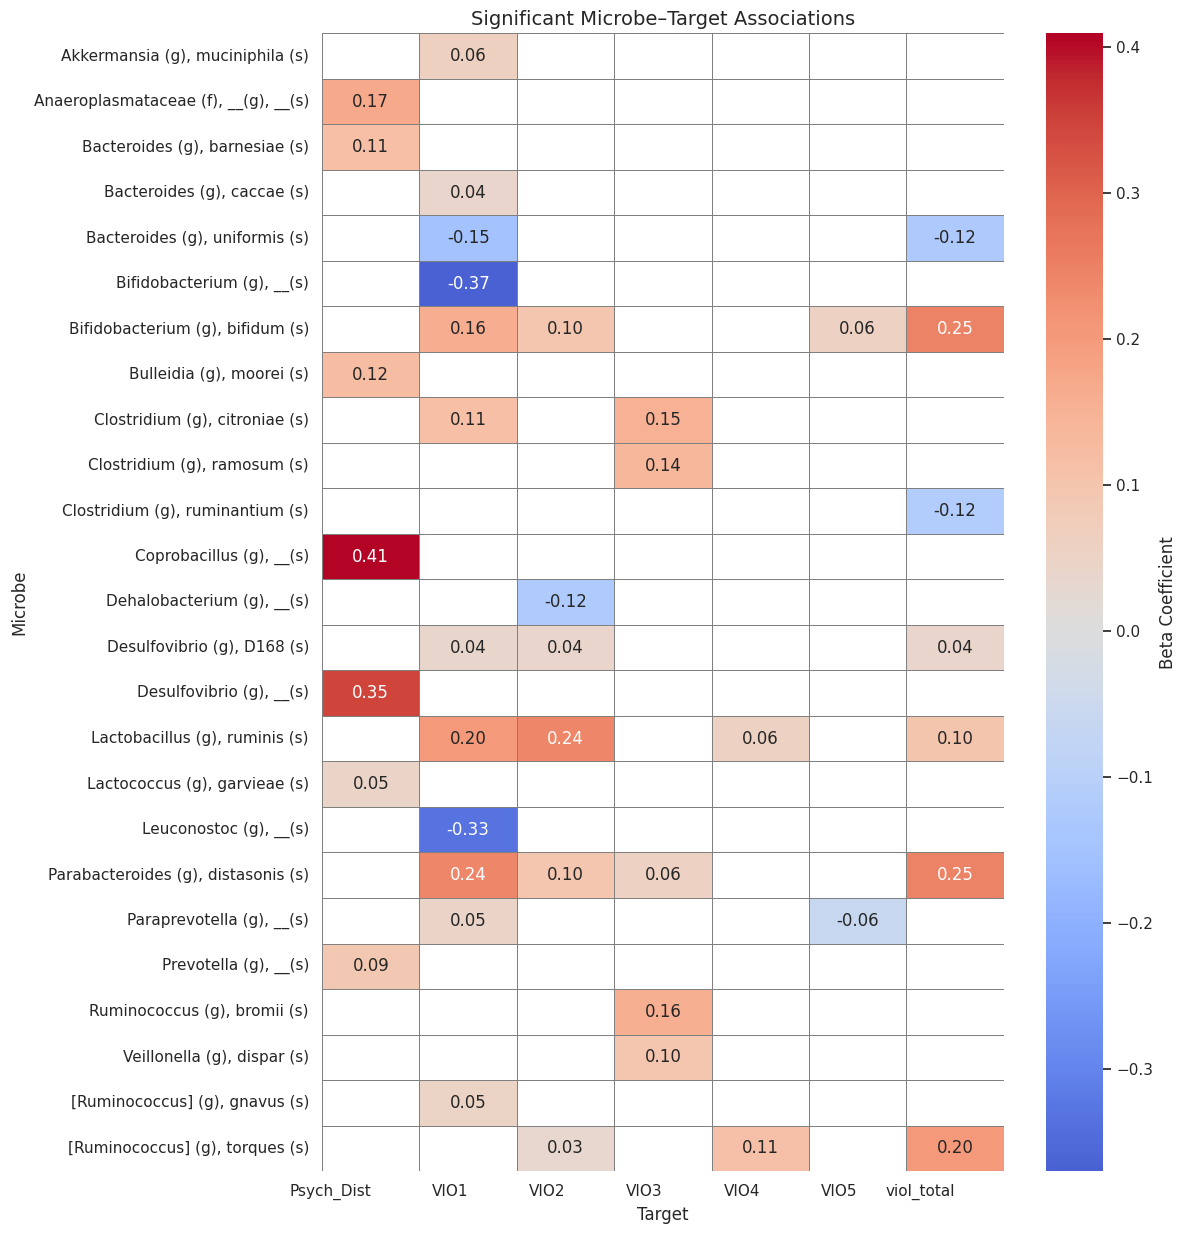

In [ ]:

def rename_microbes(features):
    renamed_features = []
    for feature in features:
        parts = feature.split(';')
        Class = next((part.split('__')[1] for part in parts if part.startswith('c__')), '')
        order = next((part.split('__')[1] for part in parts if part.startswith('o__')), '')
        family = next((part.split('__')[1] for part in parts if part.startswith('f__')), '')
        genus = next((part.split('__')[1] for part in parts if part.startswith('g__')), '')
        species = next((part.split('__')[1] for part in parts if part.startswith('s__')), '')
        if species != '' and genus != '':
            renamed_features.append(f"{genus} (g), {species} (s)")
        elif species == '' and genus != '':
            renamed_features.append(f"{genus} (g), __(s)")
        elif genus == '' and family != '':
            renamed_features.append(f"{family} (f), __(g), __(s)")
        elif family == '' and order != '':
            renamed_features.append(f"{order} (o), __(f), __(g), __(s)")
        elif order == '':
            renamed_features.append(f"{Class} (c), __(o), __(f), __(g), __(s)")
    return renamed_features

def plot_microbe_target_heatmap(
    df,
    beta_col='Beta',
    qval_col='q-value',
    microbe_col='Microbe',
    target_col='Target',
    significance_threshold=0.05,
    figsize=(12, 8)
):
    """
    Creates a heatmap of microbe-target associations using beta coefficients.
    Only significant associations (based on q-value) are shown.

    Parameters:
    - df: input df
    - beta_col: name of the beta coefficient column
    - qval_col: name of the FDR-adjusted q-value column
    - microbe_col: name of the microbe column
    - target_col: name of the target column
    - significance_threshold: q-value cutoff for significance
    - figsize: size of the plot
    """


    # Keep only significant associations
    df_sig = df[df[qval_col] < significance_threshold]

    # Pivot the table to Microbe x Target with Beta as values
    heatmap_data = df_sig.pivot(index=microbe_col, columns=target_col, values=beta_col)

    # Sort microbes and targets alphabetically
    heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

    # Plot
    num_microbes = heatmap_data.shape[0]
    row_height = 0.5
    plt.figure(figsize=(12, num_microbes * row_height))
    #plt.figure(figsize=figsize)
    sns.set(style='white')

    ax = sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Beta Coefficient'},
        annot=True,
        fmt=".2f"
    )

    plt.title("Significant Microbe–Target Associations", fontsize=14)
    plt.xlabel("Target")
    plt.ylabel("Microbe")
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

#################################################################

# Lituruture Visualization
results_df = pd.read_csv("Microbes_with_statistics_all.csv")
microbes_names = rename_microbes(results_df['Microbe'])
results_df['Microbe'] = [microbe.replace("_0", "") for microbe in microbes_names]
plot_microbe_target_heatmap(results_df)


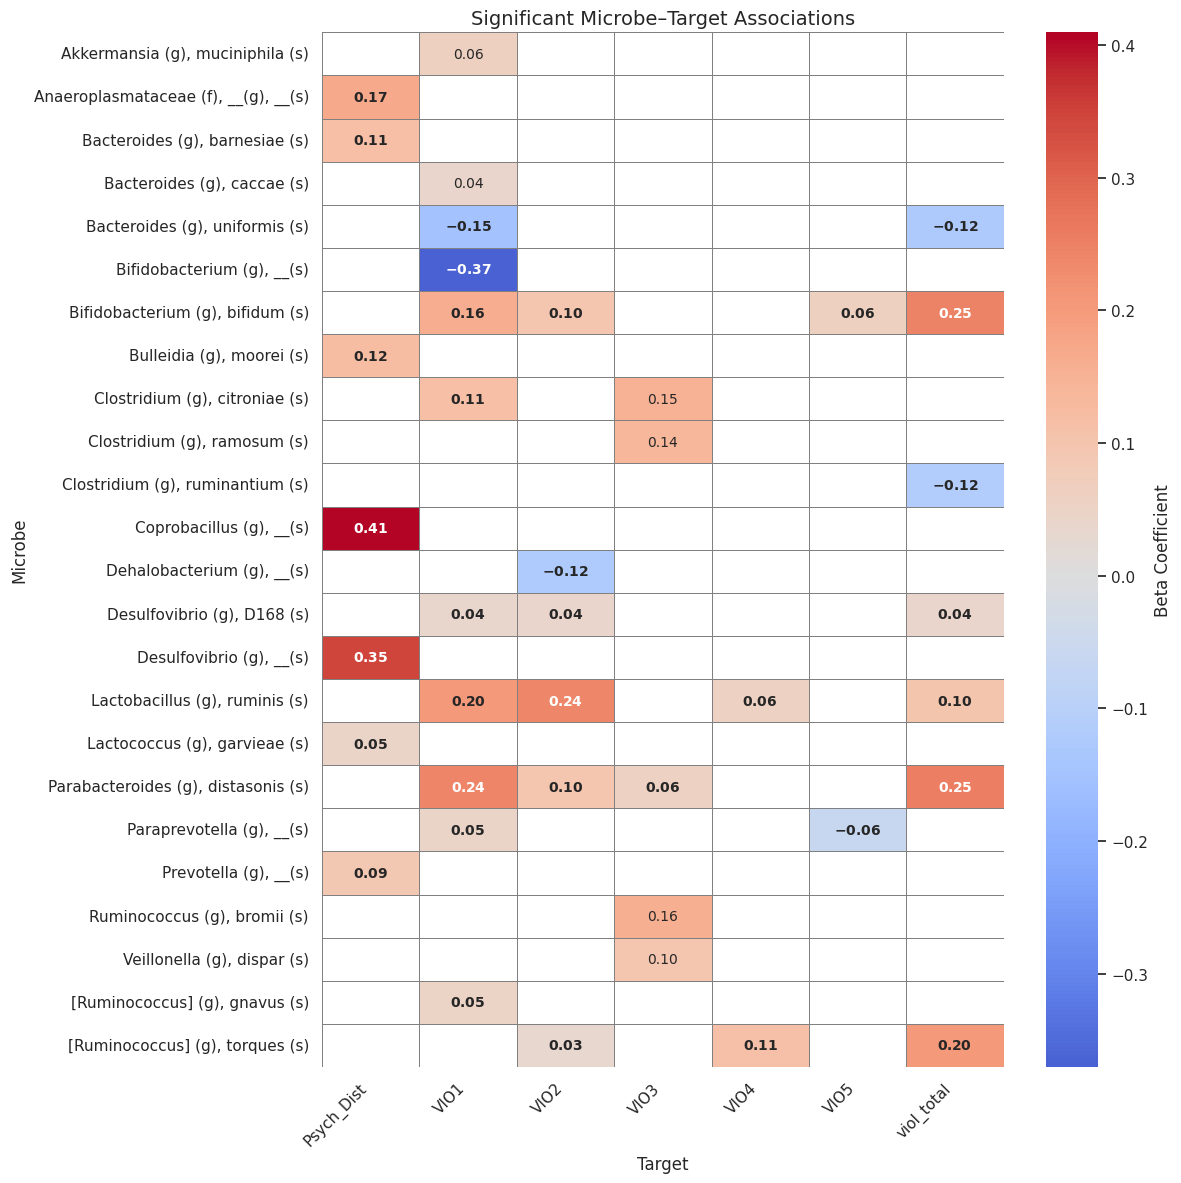

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def rename_microbes(features):
    renamed_features = []
    for feature in features:
        parts = feature.split(';')
        Class = next((part.split('__')[1] for part in parts if part.startswith('c__')), '')
        order = next((part.split('__')[1] for part in parts if part.startswith('o__')), '')
        family = next((part.split('__')[1] for part in parts if part.startswith('f__')), '')
        genus = next((part.split('__')[1] for part in parts if part.startswith('g__')), '')
        species = next((part.split('__')[1] for part in parts if part.startswith('s__')), '')
        if species != '' and genus != '':
            renamed_features.append(f"{genus} (g), {species} (s)")
        elif species == '' and genus != '':
            renamed_features.append(f"{genus} (g), __(s)")
        elif genus == '' and family != '':
            renamed_features.append(f"{family} (f), __(g), __(s)")
        elif family == '' and order != '':
            renamed_features.append(f"{order} (o), __(f), __(g), __(s)")
        elif order == '':
            renamed_features.append(f"{Class} (c), __(o), __(f), __(g), __(s)")
    return renamed_features

def plot_microbe_target_heatmap(
    df,
    beta_col='Beta',
    pval_col='p-value',
    qval_col='q-value',
    microbe_col='Microbe',
    target_col='Target',
    significance_threshold=0.05,
    figsize=(12, 8)
):
    """
    Creates a heatmap of microbe-target associations using beta coefficients.
    Only significant associations (based on q-value) are shown.
    Significant entries will be bolded in the heatmap annotations.
    """

    # Keep only rows with a q-value and beta
    df = df.dropna(subset=[beta_col, qval_col])

    # Keep only significant associations
    df_sig = df[df[qval_col] < significance_threshold]

    # Pivot the table to Microbe x Target with Beta as values
    heatmap_data = df_sig.pivot(index=microbe_col, columns=target_col, values=beta_col)

    # Create full matrix for annotation (including non-significant values as NaNs)
    beta_matrix = df.pivot(index=microbe_col, columns=target_col, values=beta_col)
    qval_matrix = df.pivot(index=microbe_col, columns=target_col, values=qval_col)

    # Build annotation array with bolding for significant values
    annot = beta_matrix.copy().astype(str)
    for row in annot.index:
        for col in annot.columns:
            beta_val = beta_matrix.loc[row, col]
            q_val = qval_matrix.loc[row, col]
            if pd.notna(beta_val):
                formatted = f"{beta_val:.2f}"
                if pd.notna(q_val) and q_val < significance_threshold:
                    formatted = r"$\bf{" + formatted + "}$"  # bold in matplotlib
                annot.loc[row, col] = formatted
            else:
                annot.loc[row, col] = ""

    # Sort rows and columns
    beta_matrix = beta_matrix.sort_index().sort_index(axis=1)
    annot = annot.loc[beta_matrix.index, beta_matrix.columns]

    # Plot
    num_microbes = beta_matrix.shape[0]
    row_height = 0.5
    plt.figure(figsize=(12, max(num_microbes * row_height, 6)))
    sns.set(style='white')

    ax = sns.heatmap(
        beta_matrix,
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Beta Coefficient'},
        annot=annot.values,
        fmt='',
        annot_kws={"size": 10, "va": "center", "ha": "center"},
    )

    plt.title("Significant Microbe–Target Associations", fontsize=14)
    plt.xlabel("Target")
    plt.ylabel("Microbe")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#################################################################

# Lituruture Visualization
results_df = pd.read_csv("Microbes_with_statistics_all.csv")
microbes_names = rename_microbes(results_df['Microbe'])
results_df['Microbe'] = [microbe.replace("_0", "") for microbe in microbes_names]
plot_microbe_target_heatmap(results_df)

### Compute median, IQR, mean, and std based on the microbes abundence

In [ ]:
import pandas as pd
from scipy.stats import iqr

# Load data
results_df = pd.read_csv("Microbes_with_statistics_all.csv")
abundances_df = pd.read_csv("MIPMLP_format_filtered.csv")

# Clean microbe names
results_df['Microbe'] = results_df['Microbe'].str.replace("_0", "", regex=False)

# Initialize dictionaries
median_dict = {}
iqr_dict = {}
mean_dict = {}
std_dict = {}

# Compute stats per microbe
for microbe in results_df['Microbe']:
    if microbe in abundances_df.columns:
        values = abundances_df[microbe]
        median_dict[microbe] = values.median()
        iqr_dict[microbe] = iqr(values)
        mean_dict[microbe] = values.mean()
        std_dict[microbe] = values.std()
    else:
        median_dict[microbe] = None
        iqr_dict[microbe] = None
        mean_dict[microbe] = None
        std_dict[microbe] = None

# Add columns to results_df
results_df['Median Abundance'] = results_df['Microbe'].map(median_dict)
results_df['IQR Abundance'] = results_df['Microbe'].map(iqr_dict)
results_df['Mean Abundance'] = results_df['Microbe'].map(mean_dict)
results_df['STD Abundance'] = results_df['Microbe'].map(std_dict)

# Save to file
results_df.to_csv("Microbes_with_statistics_all_with_abundance.csv", index=False)


k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__bifidum
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__bifidum
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__bifidum
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__bifidum
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella;s__
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__[Paraprevotellaceae];g__Paraprevotella;s__
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__barnesiae
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g_

# **Canonical Correlation Analysis**

In [ ]:
from sklearn.cross_decomposition import CCA

# Define groups
inflammation_distress = ['crp', 'fibrinogen', 'Psych_Dist']
vio = ['VIO1', 'VIO2', 'VIO3', 'VIO4', 'VIO5']

# df_metadata = pd.read_csv('metadata.csv')
# df_MIPMLP = pd.read_csv('MIPMLP.csv')

# Handle missing values
for feature in inflammation_distress + vio:
   df_metadata[feature] = df_metadata[feature].apply(lambda x: np.nan if x == ' ' else float(x))
# Drop rows with NaN values in target columns
df_metadata.dropna(subset=inflammation_distress + vio, inplace=True)
df_MIPMLP = df_MIPMLP.loc[df_metadata.index]


# Extract the relevant columns for each group
X = df_metadata[inflammation_distress]
Y = df_metadata[vio]

# Perform CCA
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X, Y)

# Get the coefficients
coeff_X = cca.x_weights_
coeff_Y = cca.y_weights_

# Compute the new measures (canonical variables)
# X_c = pd.DataFrame(X_c, columns=[f'Canonical_Variable_X{i+1}' for i in range(X_c.shape[1])])
# Y_c = pd.DataFrame(Y_c, columns=[f'Canonical_Variable_Y{i+1}' for i in range(Y_c.shape[1])])
X_c = pd.DataFrame(X_c, columns=[f'Canonical_Variable_X'])
Y_c = pd.DataFrame(Y_c, columns=[f'Canonical_Variable_Y'])
df_metadata['inflammation_distress'] = X_c
df_metadata['vio'] = Y_c

# Save the coefficients and canonical variables to CSV files
# coeff_X_df = pd.DataFrame(coeff_X, index=inflammation_distress, columns=[f'Canonical_Coeff_X{i+1}' for i in range(coeff_X.shape[1])])
# coeff_Y_df = pd.DataFrame(coeff_Y, index=vio, columns=[f'Canonical_Coeff_Y{i+1}' for i in range(coeff_Y.shape[1])])
coeff_X_df = pd.DataFrame(coeff_X, index=inflammation_distress, columns=[f'Canonical_Coeff_X'])
coeff_Y_df = pd.DataFrame(coeff_Y, index=vio, columns=[f'Canonical_Coeff_Y'])

coeff_X_df.to_csv('canonical_coefficients_X.csv', index=True)
coeff_Y_df.to_csv('canonical_coefficients_Y.csv', index=True)
X_c.to_csv('canonical_variables_X.csv', index=False)
Y_c.to_csv('canonical_variables_Y.csv', index=False)

print("Canonical Coefficients for X (inflammation_distress):")
print(coeff_X_df)
print("\nCanonical Coefficients for Y (vio):")
print(coeff_Y_df)

print("\nCanonical Variables for X (inflammation_distress):")
print(X_c)
print("\nCanonical Variables for Y (vio):")
print(Y_c)


Canonical Coefficients for X (inflammation_distress):
            Canonical_Coeff_X
crp                 -0.062959
fibrinogen          -0.003077
Psych_Dist           0.998011

Canonical Coefficients for Y (vio):
      Canonical_Coeff_Y
VIO1           0.593208
VIO2          -0.385460
VIO3           0.627869
VIO4           0.165001
VIO5           0.279427

Canonical Variables for X (inflammation_distress):
     Canonical_Variable_X
0                1.348239
1               -0.508622
2               -0.942525
3               -0.521495
4                1.126094
..                    ...
294             -1.384947
295             -0.496662
296              2.568768
297             -0.700289
298              1.177429

[299 rows x 1 columns]

Canonical Variables for Y (vio):
     Canonical_Variable_Y
0                0.421118
1                0.205813
2               -0.075224
3               -0.974556
4                0.206136
..                    ...
294             -0.743665
295            

### Visualization

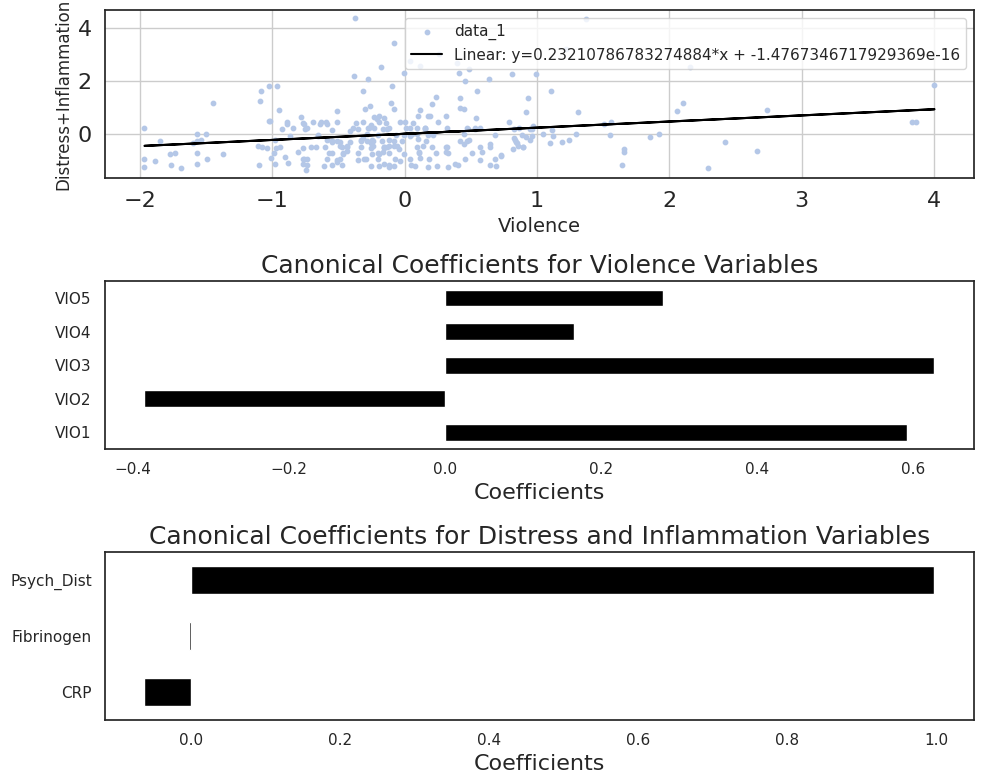

In [ ]:
# Plotting the relationship between the canonical variables
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.scatter(Y_c, X_c, label='data_1', color=(180/255, 199/255, 231/255), s=10)
plt.xlabel('Violence', fontsize=14)
plt.ylabel('Distress+Inflammation', fontsize=12)
#plt.title('Canonical Correlation Analysis', fontsize=16)

# Fit linear and quadratic models for illustration
z = np.polyfit(Y_c['Canonical_Variable_Y'], X_c['Canonical_Variable_X'], 1)
p = np.poly1d(z)
plt.plot(Y_c, p(Y_c), color='Black', label=f"Linear: y={z[0]}*x + {z[1]}") #:.4f

# z = np.polyfit(Y_c['Canonical_Variable_Y'], X_c['Canonical_Variable_X'], 2)
# p = np.poly1d(z)
# plt.plot(Y_c, p(Y_c), "purple", label=f"Quadratic: y={z[0]:.4f}*x^2 + {z[1]:.4f}*x + {z[2]:.4f}")

plt.legend()
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

coeff_X_df.rename(index={'crp': 'CRP', 'fibrinogen': 'Fibrinogen'}, inplace=True)
# Plotting the coefficients for each group
plt.subplot(3, 1, 2)
coeff_Y_df.plot(kind='barh', legend=False, ax=plt.gca(), color = 'black')
plt.xlabel('Coefficients', fontsize=16)
#plt.ylabel('Variables')
plt.title('Canonical Coefficients for Violence Variables', fontsize=18)

plt.subplot(3, 1, 3)
coeff_X_df.plot(kind='barh', legend=False, ax=plt.gca(), color = 'black')
plt.xlabel('Coefficients', fontsize=16)
#plt.ylabel('Variables')
plt.title('Canonical Coefficients for Distress and Inflammation Variables', fontsize=18)

plt.tight_layout()
plt.show()


# **Regression model with CCA results**

In [ ]:
from statsmodels.stats.multitest import multipletests

# Define target values and independent variables
targets = [ 'inflammation_distress']
independent_vars = ['bmi', 'Age', 'SEX_0M', 'vio'] # 'inflammation_distress'
numeric_features = ['bmi', 'Age']
binary_features = ['SEX_0M']

# pre-process data
for col in numeric_columns:
    df_metadata[col] = pd.to_numeric(df_metadata[col], errors='coerce')
# Drop rows with NaN values in target columns
df_metadata.dropna(subset=targets, inplace=True)
# Drop corresponding rows in df_MIPMLP
df_MIPMLP = df_MIPMLP.loc[df_metadata.index]
# Impute NaN values for numeric features using median and standardize it using z-score
numeric_imputer = SimpleImputer(strategy='median')
numeric_imputed_values = numeric_imputer.fit_transform(df_metadata[numeric_features])
df_metadata[numeric_features] = numeric_imputed_values
# # Z-score
# scaler = StandardScaler()
# df_metadata[numeric_features] = scaler.fit_transform(df_metadata[numeric_features])
# Impute NaN values for binary features using most frequent value
binary_imputer = SimpleImputer(strategy='most_frequent')
binary_imputed_values = binary_imputer.fit_transform(df_metadata[binary_features])
df_metadata[binary_features] = binary_imputed_values

# List to store significant microbes and their p-values
significant_microbes = []
significant_microbes_dict = {microbe: set() for microbe in df_MIPMLP.columns}
significant_microbes_dict_adj = {microbe: set() for microbe in df_MIPMLP.columns}

# Iterate through each target
for target in targets:
    # Split the data into training and testing sets
    train_meta, test_meta, train_microbes, test_microbes = train_test_split(df_metadata, df_MIPMLP, test_size=0.2, random_state=42)

    # Iterate through each microbe
    for microbe in df_MIPMLP.columns[1:]:
        # Prepare the training data
        X_train = train_meta[independent_vars].copy()
        X_train['microbe'] = train_microbes[microbe]
        y_train = train_meta[target]

        # Add a constant term for the intercept
        X_train = sm.add_constant(X_train)

        # Build and fit the regression model
        model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

        # Check if the microbe is significant
        if model.pvalues['microbe'] < 0.05:
           coefficient = model.params['microbe']
           significant_microbes.append((microbe, target, model.pvalues['microbe'],coefficient))
           significant_microbes_dict[microbe].add(target)

# Convert the results to a DataFrame for better readability
significant_microbes_df = pd.DataFrame(significant_microbes, columns=['Microbe', 'Target', 'p-value', 'Coefficient'])
significant_microbes_df= significant_microbes_df.sort_values(by='p-value')

# Apply Benjamini-Hochberg correction
significant_microbes_df['adjusted_p-value'] = multipletests(significant_microbes_df['p-value'], method='fdr_bh')[1]

# Save the results to a CSV file
significant_microbes_df.to_csv('Microbes_with_statistics_CCA.csv', index=False)

print(significant_microbes_df)

# Find overlapping significant microbes
print("\n\n Significant microbes in more than 2 targets:")
for microbe, targets in significant_microbes_dict.items():
    if len(targets) > 2:
       print(f"Significant Microbes: {microbe}, Target: {targets}")
print("\n\n Significant microbes in more than 1 targets")
for microbe, targets in significant_microbes_dict.items():
    if len(targets) > 1:
        print(f"Significant Microbes: {microbe}, Target: {targets}")

                                              Microbe                 Target  \
14  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  inflammation_distress   
18  k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o...  inflammation_distress   
16  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  inflammation_distress   
12  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  inflammation_distress   
3   k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  inflammation_distress   
19  k__Bacteria;p__Verrucomicrobia;c__Verrucomicro...  inflammation_distress   
0   k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  inflammation_distress   
17  k__Bacteria;p__Tenericutes;c__Mollicutes;o__RF...  inflammation_distress   
7   k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  inflammation_distress   
6   k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  inflammation_distress   
15    k__Bacteria;p__Firmicutes_0;c__;o__;f__;g__;s__  inflammation_distress   
11  k__Bacteria;p__Firmicutes;c__Erysipe

### Visualization

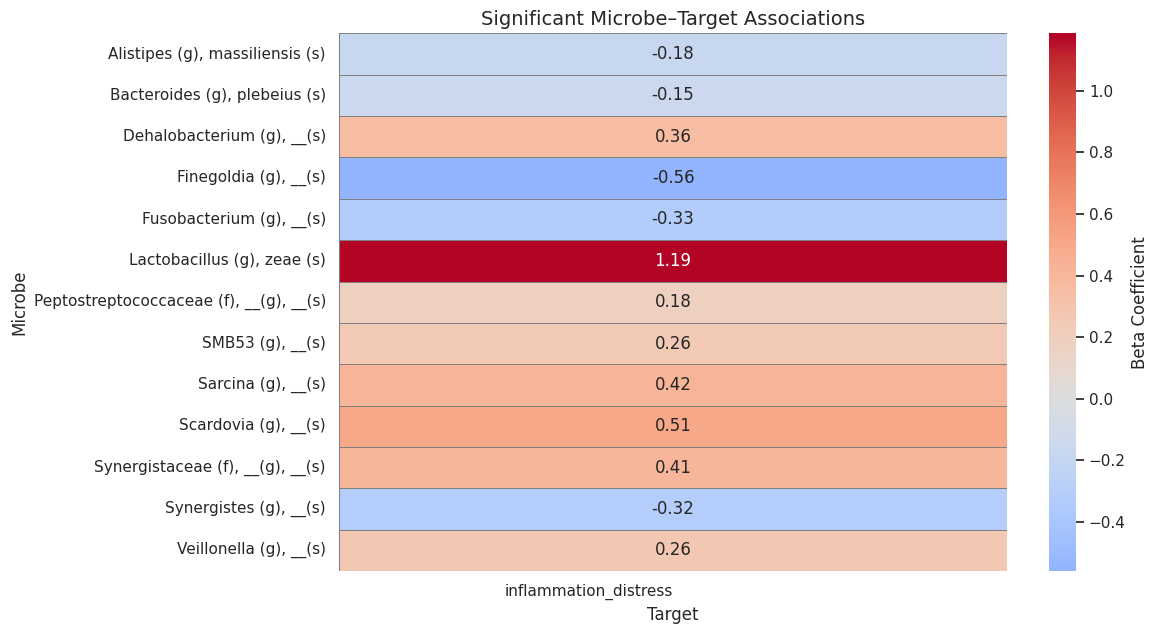

In [ ]:
# CCA Visualization

def rename_microbes(features):
    renamed_features = []
    for feature in features:
        parts = feature.split(';')
        Class = next((part.split('__')[1] for part in parts if part.startswith('c__')), '')
        order = next((part.split('__')[1] for part in parts if part.startswith('o__')), '')
        family = next((part.split('__')[1] for part in parts if part.startswith('f__')), '')
        genus = next((part.split('__')[1] for part in parts if part.startswith('g__')), '')
        species = next((part.split('__')[1] for part in parts if part.startswith('s__')), '')
        if species != '' and genus != '':
            renamed_features.append(f"{genus} (g), {species} (s)")
        elif species == '' and genus != '':
            renamed_features.append(f"{genus} (g), __(s)")
        elif genus == '' and family != '':
            renamed_features.append(f"{family} (f), __(g), __(s)")
        elif family == '' and order != '':
            renamed_features.append(f"{order} (o), __(f), __(g), __(s)")
        elif order == '':
            renamed_features.append(f"{Class} (c), __(o), __(f), __(g), __(s)")
    return renamed_features

def plot_microbe_target_heatmap(
    df,
    beta_col='Beta',
    qval_col='q-value',
    microbe_col='Microbe',
    target_col='Target',
    significance_threshold=0.05,
    figsize=(12, 8)
):
    """
    Creates a heatmap of microbe-target associations using beta coefficients.
    Only significant associations (based on q-value) are shown.

    Parameters:
    - df: input df
    - beta_col: name of the beta coefficient column
    - qval_col: name of the FDR-adjusted q-value column
    - microbe_col: name of the microbe column
    - target_col: name of the target column
    - significance_threshold: q-value cutoff for significance
    - figsize: size of the plot
    """


    # Keep only significant associations
    df_sig = df[df[qval_col] < significance_threshold]

    # Pivot the table to Microbe x Target with Beta as values
    heatmap_data = df_sig.pivot(index=microbe_col, columns=target_col, values=beta_col)

    # Sort microbes and targets alphabetically
    heatmap_data = heatmap_data.sort_index().sort_index(axis=1)

    # Plot
    num_microbes = heatmap_data.shape[0]
    row_height = 0.5
    plt.figure(figsize=(12, num_microbes * row_height))
    #plt.figure(figsize=figsize)
    sns.set(style='white')

    ax = sns.heatmap(
        heatmap_data,
        cmap='coolwarm',
        center=0,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Beta Coefficient'},
        annot=True,
        fmt=".2f"
    )

    plt.title("Significant Microbe–Target Associations", fontsize=14)
    plt.xlabel("Target")
    plt.ylabel("Microbe")
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()

results_df = pd.read_csv("Microbes_with_statistics_CCA.csv")
microbes_names = rename_microbes(results_df['Microbe'])
results_df['Microbe'] = [microbe.replace("_0", "") for microbe in microbes_names]
plot_microbe_target_heatmap(results_df)

In [ ]:
import pandas as pd
from scipy.stats import iqr

# Load data
results_df = pd.read_csv("Microbes_with_statistics_CCA.csv")
abundances_df = pd.read_csv("MIPMLP_format_filtered.csv")

# Clean microbe names
results_df['Microbe'] = results_df['Microbe'].str.replace("_0", "", regex=False)
abundances_df.columns = abundances_df.columns.str.replace("_.1", "", regex=False)

# Initialize dictionaries
median_dict = {}
iqr_dict = {}
mean_dict = {}
std_dict = {}

# Compute stats per microbe
for microbe in results_df['Microbe']:
    if microbe in abundances_df.columns:
        values = abundances_df[microbe]
        median_dict[microbe] = values.median()
        iqr_dict[microbe] = iqr(values)
        mean_dict[microbe] = values.mean()
        std_dict[microbe] = values.std()
    else:
        median_dict[microbe] = None
        iqr_dict[microbe] = None
        mean_dict[microbe] = None
        std_dict[microbe] = None

# Add columns to results_df
results_df['Median Abundance'] = results_df['Microbe'].map(median_dict)
results_df['IQR Abundance'] = results_df['Microbe'].map(iqr_dict)
results_df['Mean Abundance'] = results_df['Microbe'].map(mean_dict)
results_df['STD Abundance'] = results_df['Microbe'].map(std_dict)

# Save to file
results_df.to_csv("Microbes_with_statistics_CCA_with_abundance.csv", index=False)

# **Overlap Significant Microbes**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# Define target values and independent variables
targets = ['inflammation_distress']
independent_vars = ['bmi', 'Age', 'SEX_0M', 'vio'] # 'inflammation_distress'
numeric_features = ['bmi', 'Age']
binary_features = ['SEX_0M']

# Pre-process data
for col in numeric_features:
    df_metadata[col] = pd.to_numeric(df_metadata[col], errors='coerce')
# Drop rows with NaN values in target columns
df_metadata.dropna(subset=targets, inplace=True)
# Drop corresponding rows in df_MIPMLP
df_MIPMLP = df_MIPMLP.loc[df_metadata.index]
# Impute NaN values for numeric features using median and standardize them using z-score
numeric_imputer = SimpleImputer(strategy='median')
numeric_imputed_values = numeric_imputer.fit_transform(df_metadata[numeric_features])
df_metadata[numeric_features] = numeric_imputed_values
# Impute NaN values for binary features using the most frequent value
binary_imputer = SimpleImputer(strategy='most_frequent')
binary_imputed_values = binary_imputer.fit_transform(df_metadata[binary_features])
df_metadata[binary_features] = binary_imputed_values

# List to store significant variables and their p-values
significant_results = []

# Iterate through each target
for target in targets:
    # Split the data into training and testing sets
    train_meta, test_meta, train_microbes, test_microbes = train_test_split(df_metadata, df_MIPMLP, test_size=0.2, random_state=42)

    # Iterate through each microbe
    for microbe in df_MIPMLP.columns[1:]:
        # Prepare the training data
        X_train = train_meta[independent_vars].copy()
        X_train['microbe'] = train_microbes[microbe]
        y_train = train_meta[target]

        # Add a constant term for the intercept
        X_train = sm.add_constant(X_train)

        # Build and fit the regression model
        model = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

        # Store the significant results
        for var in ['microbe'] + independent_vars:
            if model.pvalues[var] < 0.05:
                coefficient = model.params[var]
                significant_results.append((var, microbe, target, model.pvalues[var], coefficient))

# Convert the results to a DataFrame for better readability
significant_results_df = pd.DataFrame(significant_results, columns=['Variable', 'Microbe', 'Target', 'p-value', 'Coefficient'])
significant_results_df = significant_results_df.sort_values(by='p-value')

# Apply Benjamini-Hochberg correction
significant_results_df['adjusted_p-value'] = multipletests(significant_results_df['p-value'], method='fdr_bh')[1]

print(significant_results_df)

# Find overlapping significant microbes
print("\n\nSignificant variables in more than 2 targets:")
significant_variables_dict = significant_results_df.groupby('Variable')['Target'].apply(set).to_dict()
for variable, targets in significant_variables_dict.items():
    if len(targets) > 2:
        print(f"Significant Variable: {variable}, Targets: {targets}")

print("\n\nSignificant variables in more than 1 target:")
for variable, targets in significant_variables_dict.items():
    if len(targets) > 1:
        print(f"Significant Variable: {variable}, Targets: {targets}")


    Variable                                            Microbe  \
84   microbe  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...   
106      vio  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
152      vio  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
105  microbe  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
260      vio  k__Bacteria;p__Synergistetes;c__Synergistia;o_...   
..       ...                                                ...   
180  microbe  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
188  microbe  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
256  microbe  k__Bacteria;p__Synergistetes;c__Synergistia;o_...   
107  microbe  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
211  microbe  k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...   

                    Target   p-value  Coefficient  adjusted_p-value  
84   inflammation_distress  0.000110     1.186849          0.001397  
106  inflammation_distress  0.000143     0.302336      